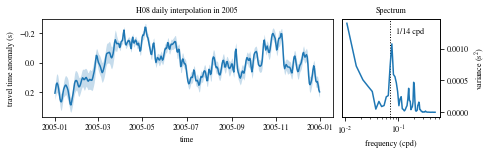

In [3]:
from scipy import signal
f = h5py.File('results/ofes/nias_tm_H08_coarsen.h5', 'r')
list(f.keys())
t = np.arange('2005-01-01', '2006-01-01', dtype='datetime64[D]')
dt = np.array(f['τi'])
ei = np.array(f['eτi'])
fig,ax = plt.subplots(1,2,figsize=(8.5,1.8),gridspec_kw={'width_ratios': [3,1]})
ax[0].fill_between(t, (dt[0] - 2*ei[0]),(dt[0] + 2*ei[0]),
                alpha=.25,color="tab:blue", linewidths=0)
ax[0].plot(t,dt[0])
ax[0].invert_yaxis()
ax[0].set_title('H08 daily interpolation in 2005')
ax[0].set_xlabel('time')
ax[0].set_ylabel('travel time anomaly (s)')
nsub = 183
idx3 = [[0,nsub],[nsub,2*nsub],[int(nsub/2),int(nsub/2)+nsub]]
for sigm in [dt[0]]:#[dTe[:,ko],ds.itemp.values[:,ke]]:
    psd3 = []
    sigm -= np.nanmean(sigm)
    sigm = signal.detrend(sigm)
    for k in range(3):
        i1,i2 = idx3[k]
        s = (sigm[i1:i2])#-np.nanmean(sigm[i1:i2])
        tmphan=np.hanning(len(s))
        PSD,FFT,om = make_FFT1D(tmphan*s,t[i1:i2],1)
        psd3.append(PSD)
    oidx = np.where(om>1e-2)
    psd3 = np.array(psd3)
    ax2 = ax[1].twinx()
    ax2.semilogx(om[oidx],om[oidx]*psd3.mean(axis=0)[oidx])
ax[1].axvline(1/14,c='k',ls=':',lw=1)
ax[1].text(0.09,0.85,'1/14 cpd')
ax[1].set_title('Spectrum')
ax[1].set_xlabel(r'frequency (cpd)')
ax[1].set_yticks([])
ax2.set_ylabel(r'variance ($\mathrm{s}^2$)')
fig.subplots_adjust(left = 0.25, wspace = 0.05)
fig.savefig(f'results/Nias/H08_zoomin_2005.png', bbox_inches='tight',dpi=300)
plt.show()

In [2]:
from argopy import DataFetcher as ArgoDataFetcher
import numpy as np
argo_loader = ArgoDataFetcher()
def getFloats(region_params):
    print(f'From {region_params[-2]} to {region_params[-1]}')
    print('Loading data...')
    ds = None
    while ds is None:
        try:
            # connect
            ds = argo_loader.region(region_params).to_xarray()
        except:
             pass
    print('Download finished!\n')
    
    t_flts = [np.datetime64()]
    latlon_flts = np.array([ds.LONGITUDE.values,ds.LATITUDE.values]).T
    ll_eflts = np.unique(latlon_flts,axis=0)
    return ll_eflts,np.unique(ds.TIME.values)

region_params = [72,97,-8,2,0.,2000.]
llt_flts = []
dt_params = [f'2005-01-01',f'2005-12-31']
params = region_params + dt_params
llt_flts.append(getFloats(params))

From 2005-01-01 to 2005-12-31
Loading data...
Download finished!



In [2]:
import gsw as gsw
# in situ temperature from potential temperature
def T(pT, S, lon, lat, z):
    p = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, p, lon, lat)
    CT = gsw.CT_from_pt(SA, pT)
    T = gsw.t_from_CT(SA, CT, p)
    return T

# in situ density as a function of salinity and temperature
def sigma0(pT, S, lon, lat, z):
    p = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, p, lon, lat)
    CT = gsw.CT_from_pt(SA, pT)
    prho0 = gsw.sigma0(SA, CT)
    return prho0

ds_temp = xr.open_dataset('data/ofes/temp_ofes_2005_dy.nc')
ds_salt = xr.open_dataset('data/ofes/salinity_ofes_2005_dy.nc')
lon_e = ds_temp.lon.values
lat_e = ds_temp.lat.values
ze = -ds_temp.lev.values
xm,ym = 84.5,-3
im,jm = np.argmin(np.abs(lon_e-xm)),np.argmin(np.abs(lat_e-ym))
temp = ds_temp.temp.isel(lat=jm,lon=im).values
salt = ds_salt.salinity.isel(lat=jm,lon=im).values
itmp = T(temp,salt,xm,ym,ze[None,:])

In [2]:
ds = xr.open_dataset(f'results/ecco/dtaus_Nias_H08_ecco_{grid}KTs.nc')
#ds = ds.sel(t=slice(np.datetime64('2000-01-01'),np.datetime64('2017-12-31')))
ds

<xarray.Dataset>
Dimensions:   (f: 3, t: 6575)
Coordinates:
  * f         (f) int32 2 3 4
  * t         (t) datetime64[ns] 2000-01-01 2000-01-02 ... 2017-12-30 2017-12-31
Data variables:
    SEMdtaus  (f, t) float64 ...
Attributes:
    description:  Daily kernel-weighted anomalies estimated from ECCOv4r4

183
-0.045278452871923204
-0.10381429612245194
-0.12410519131714023


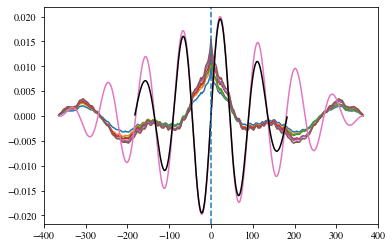

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
from scipy.optimize import curve_fit
from scipy import signal
from numpy import fft
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({"font.size": 10})
plt.rcParams.update({'axes.titlesize': 'medium'})

def crscov(s1,s2,lt,method='N'):
    n0 = len(s1)
    if method=='N':
        n = len(s1)
        lt = min(lt,n0-1)
    elif method=='k':
        lt = min(lt,n0-2)
    cc = np.zeros(2*lt+1)
    if method=='fft':
        wt = np.hanning(n0)
        s1,s2 = s1*wt,s2*wt
        power_spectrum = fft.rfft(s1)*np.conjugate(fft.rfft(s2))    
        
        # Compute inverse Fourier transform of power spectrum
        cov = fft.irfft(power_spectrum,n0,norm=None)
        # calculate normalization factors
        norm1 = fft.irfft(np.conjugate(fft.rfft(s1**2))*fft.rfft(np.ones(n0)), n0)
        norm2 = fft.irfft(np.conjugate(fft.rfft(s2**2))*fft.rfft(np.ones(n0)), n0)
        cov = cov/np.sqrt(norm1*norm2)
        # Shift the result such that the autocorrelation maximum is at the center
        cov = np.fft.fftshift(cov)
        lt = (n0-1)/2
            
        return np.linspace(-lt,n0-1-lt,n0),cov
    else:
        for i in range(lt):
            s1i=s1[:i+n0-lt]
            s2i=s2[lt-i:]
            if method=='k':
                n = len(s1i)
            cc[i] = (s1i*s2i).sum()/(n-1)
        for i in range(lt+1):
            s1i=s1[i:]
            s2i=s2[:n0-i]
            if method=='k':
                n = len(s1i)
            cc[lt+i]=(s1i*s2i).sum()/(n-1)
        return np.linspace(-lt,lt,2*lt+1),cc

year = 365.2425
def f1d(x, k, b):
    return k*x+b

model,grid='ofes','Gaussian'
ds = xr.open_mfdataset(f'results/{model}/kTdT_Nias_H08_2005_{grid}.nc')
t = ds['t'].values
nsub = int(len(t)/2)+1*(len(t)%2)
print(nsub)
t = (t-t[nsub])/np.timedelta64(1,'D')
tt = (t**2).sum()
tau3 = []
for i in range(3):
    taui = ds['SEMdtaus'].values[i]
    taui = taui-taui.mean()
    ki = (t*taui).sum()/tt
    print(f'{ki*year}')
    #fig,ax=plt.subplots()
    #ax.plot(t,taui)
    #ax.plot(t,ki*t)
    taui = taui-ki*t
    #ax.plot(t,taui)
    tau3.append(taui)

wt = np.hanning(len(t))
tdp = np.array([float(i) for i in range(-nsub,nsub+1)])
fig,ax=plt.subplots()
lagso = signal.correlation_lags(len(t), len(t))
cov3o = np.zeros([6,len(lagso)])
n = 0
for i in range(3):
    for j in range(i,3):
        taus = np.array([tau3[i],tau3[j]])
        cov0 = np.cov(taus)[0,1]
        #print(f'{cov0}, {np.linalg.det(np.cov(taus))}')
        #covij = specov(taus*wt[None,:])
        #covij = crscov(tau3[i],tau3[j],nsub)
        covij = signal.correlate(tau3[i],tau3[j])
        covij /= np.max(covij)
        ax.plot(lagso,cov0*covij)
        cov3o[n,:] = covij*cov0
        n+=1
#ax.plot(tdp-tdp.mean(),fcor(tdp-tdp.mean(), *popt))
covtest = signal.correlate(np.sin(t*np.pi/45), np.cos(t*np.pi/45),method='direct')
#specov(np.array([np.sin(t*np.pi/45),np.cos(t*np.pi/45)]))
lagst = signal.correlation_lags(len(t), len(t))
ax.plot(lagst,covtest/np.max(covtest)*0.02)
lagst,corr = crscov(np.sin(t*np.pi/45), np.cos(t*np.pi/45),len(t)-1,'fft')
#corr = signal.correlate(np.sin(t*np.pi/45), np.cos(t*np.pi/45),method='fft')
#corr /= np.max(corr)
ax.plot(lagst, corr*0.02,color='k')
#ax.set_xlim([tdp[0],tdp[1]])
ax.axvline(0,ls='--')
plt.show()

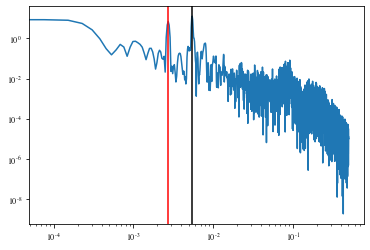

In [5]:
covij,f,spd = specov([wt*tau3[i],wt*tau3[j]],mode,True)
fig,ax=plt.subplots()
ax.loglog(f,8/3*spd)
ax.axvline(1/year,color='r')
ax.axvline(2/year,color='k')
plt.show()

6575
-0.01729306473777854
-0.020305314968821406
-0.021762859285233794


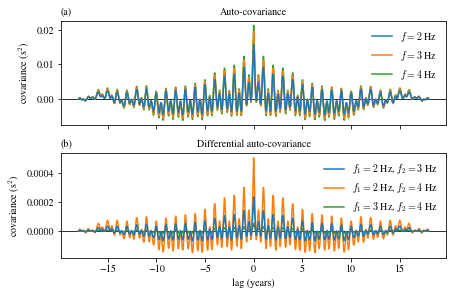

In [3]:
grid='coarsen'
import string
ast = list(string.ascii_lowercase)
model='ecco'
ds = xr.open_dataset(f'results/ecco/dtaus_Nias_H08_ecco_{grid}KTs.nc')
ds = ds.sel(t=slice(np.datetime64('2000-01-01'),np.datetime64('2017-12-31')))
t = ds['t'].values
#nsub = int(len(t)/2)+1*(len(t)%2)
print(len(t))
t = (t-np.datetime64('2000-01-01'))/np.timedelta64(1,'D')
tm = .5*(t[0]+t[-1])
X = np.ones((2,len(t)))
X[1,:]=t-tm
tau3 = []
for i in range(3):
    taui = ds['SEMdtaus'].values[i]
    taui = taui-taui.mean()
    ki = (np.linalg.inv(X@X.T)@(X@taui[:,None])).flatten()
    print(f'{ki[1]*year}')
    tau3.append(taui-ki@X)

wt = np.hanning(len(t))
#tdp = np.array([float(i) for i in range(-nsub,nsub+1)])
fig,ax = plt.subplots(2,1,figsize=(6.4, 4.2),sharex=True)
lt = len(tau3[0])#-365*3
method = 'N'
if method == 'fft':
    cov3 = np.zeros([6,len(tau3[0])])
else:
    cov3 = np.zeros([6,2*min(lt,len(tau3[0])-1)+1])
n = 0
for i in range(3):
    for j in range(i,3):
        taus = np.array([tau3[i],tau3[j]])
        cov0 = 1#np.cov(taus)[0,1]
        lags,covij = crscov(tau3[i],tau3[j],lt,method)
        #covij = specov([wt*tau3[i],wt*tau3[j]],mode)
        #covij[np.abs(lags/year)>13]=0
        #covij /= np.max(covij)
        if i==j:
            ax[0].plot(lags/year,cov0*covij,label=f'$f={ds.f[i].values:.0f}$ Hz',zorder=3-i)
        else:
            lags,covij = crscov(tau3[i]-tau3[j],tau3[i]-tau3[j],lt,method)
            ax[1].plot(lags/year,cov0*covij,
                       label=f'$f_1={ds.f[i].values:.0f}$ Hz, $f_2={ds.f[j].values:.0f}$ Hz',zorder=6-i-j)
        cov3[n,:] = covij*cov0
        n+=1

for i in range(2):
    #ax[i].axvline(0,c='k',lw=0.8,zorder=0)
    ax[i].axhline(0,c='k',lw=0.8,zorder=0)
    ax[i].set_ylabel(r'covariance (s$^2$)')
    ax[i].legend(frameon=False)
    ax[i].set_title(f'({ast[i]})', loc="left")
ax[0].set_title('Auto-covariance')
ax[-1].set_title('Differential auto-covariance')
ax[-1].set_xlabel(r'lag (years)')
plt.tight_layout()
fig.savefig(f'results/{model}/covariance.pdf', bbox_inches='tight')
plt.show()

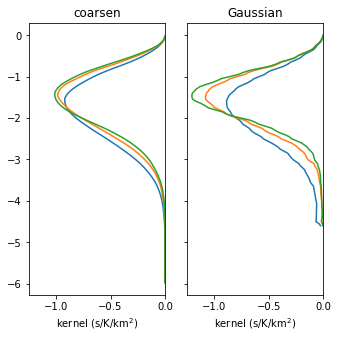

In [16]:
fig,ax=plt.subplots(1,2,figsize=(4.8,4.8),sharey=True)
for i,grid in enumerate(['coarsen','Gaussian']):
    dsk = xr.open_dataset(f'data/knl/KTs_Nias_H08_{grid}.nc')
    ax[i].plot(1e9*dsk.SEMkernels_T.values.mean(axis=1).T,dsk.z.values/1e3)
    ax[i].set_title(grid)
    ax[i].set_xlabel('kernel (s/K/km$^2$)')
    ax[i].set_xlim([-1.25,0])
plt.tight_layout()

In [3]:
import h5py

hf = h5py.File(f'data/ecco/covtau0_{grid}.h5', 'w')
hf.create_dataset('lags', data=lags)
hf.create_dataset('covs', data=cov3)
hf.close()

In [ ]:
import h5py

hf = h5py.File(f'data/ecco/covtau_{grid}.h5', 'w')
hf.create_dataset('w', data=w)
hf.create_dataset('v', data=v)
hf.create_dataset('lags', data=lagse)
hf.create_dataset('covs', data=cov3e)
hf.close()

In [4]:
import pandas as pd
df = pd.read_csv('results/Nias/twave/nias_tm_H08_tpairs.csv')
df['dtm1'] = pd.to_datetime(df['event1'], infer_datetime_format=True) 
df['dtm2'] = pd.to_datetime(df['event2'], infer_datetime_format=True) 
df['ddtm'] = (df['dtm2']-df['dtm1'])/np.timedelta64(1,'D')
df = df[(df['dtm1']>=np.datetime64('2005-01-01'))&(df['dtm2']<np.datetime64('2006-01-01'))]
df = df.sort_values(by='ddtm').reset_index(drop=True)
dte = np.unique(df[['dtm1','dtm2']]).flatten()
D = np.zeros((len(df['event1']),len(dte)))
for idx, row in df.iterrows():
    t1,t2 = row['dtm1'],row['dtm2']
    i1,i2 = list(dte).index(t1),list(dte).index(t2) 
    D[idx,i1],D[idx,i2] = -np.sign(i2-i1),np.sign(i2-i1) 
    
dte = (dte-np.datetime64('2000-01-01'))/np.timedelta64(1,'D')
dtee = (ds.t.values-np.datetime64('2000-01-01'))/np.timedelta64(1,'D')

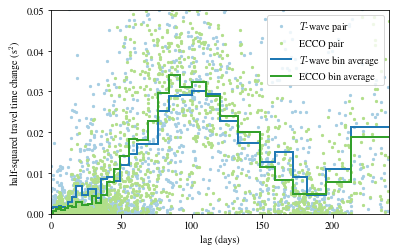

In [8]:
for i,k in zip([0],[0]):
    fig,ax=plt.subplots(figsize=(5.6,3.6))
    df['Dtauie'] = D@np.interp(dte,dtee,ds['SEMdtaus'].values[i])
    df['Dtauje'] = D@np.interp(dte,dtee,ds['SEMdtaus'].values[k])
    df['Dtaui'] = np.array([float(dts[1:-1].split(',')[i]) for dts in df['Δτ']])
    df['Dtaui'] = df['Dtaui']-df['Δτp']
    df['Dtauj'] = np.array([float(dts[1:-1].split(',')[k]) for dts in df['Δτ']])
    df['Dtauj'] = df['Dtauj']-df['Δτp']
    p1 = ax.scatter(df['ddtm'],(df['Dtaui'])*(df['Dtauj'])/2,s=5,color="#a6cee3")
    p2 = ax.scatter(df['ddtm'],(df['Dtauie'])*(df['Dtauje'])/2,s=5,color="#b2df8a")
    #ax[1].scatter(df['ddtm'],(df['Dtaui'])*(df['Dtauj'])/((df['Dtauie'])*(df['Dtauje'])),
    #              alpha=0.5,s=5,color="#7570b3",label=r'$T$-wave/ECCO')
    j = 1
    delay,dlye,rte = [],[],[]
    edges = [0]
    n,ddtmax=60,df['ddtm'].max()-1
    while j*n<len(df):
        dfj = df.iloc[(j-1)*n:j*n]
        #Dtaui += dfj['ddtm'].values*0.01/year
        #dlyj.append(((Dtaui-dfj['Δτp'])**2).mean()/2)
        delay.append(((dfj['Dtaui'])*(dfj['Dtauj'])).mean()/2)
        #dlye.append(((dfj['Dtauie']-dfj['ddtm']*0.01/year)**2).mean()/2)
        dlye.append(((dfj['Dtauie'])*(dfj['Dtauje'])).mean()/2)
        rte.append(((dfj['Dtaui'])*(dfj['Dtauj'])/((dfj['Dtauie'])*(dfj['Dtauje']))).mean())
        edges.append(dfj['ddtm'].values[-1])
        j+=1

    delay,dlye = np.array(delay),np.array(dlye)
    p3 = ax.stairs(delay,edges,color="#1f78b4",lw=2)
    p4 = ax.stairs(dlye,edges,color="#33a02c",lw=2)
    ax.set_ylabel(r'half-squared travel time change (s$^2$)')
    ax.set_xlabel(r'lag (days)')
    #ax[1].stairs(rte,edges,color='#1b9e77',lw=2,label=r'bin average')
    #ax[1].stairs((delay/dlye),edges,color='#d95f02',lw=2,label=r'ratio of averages')
    #ax.legend()
    legends = [r'$T$-wave pair','ECCO pair',r'$T$-wave bin average','ECCO bin average']
    ax.legend([p1, p2, p3,p4],
              legends, ncol=1, loc="upper right")
    ax.set_ylim([0,0.05])
    ax.set_xlim([0,240])
    #ax[1].legend()
    #ax[1].set_xlim([0,240])
    #ax[1].set_ylim([1e-2,1e3])
    #ax[1].set_ylabel(r'covariance ratio')
    #ax[1].set_yscale('log')
    #ax[1].set_xlabel(r'lag (days)')
    plt.tight_layout()
    fig.savefig(f'results/{model}/covcompare_2vs2Hz.pdf', bbox_inches='tight')
    plt.show()

In [6]:
df['rij']=(df['Dtaui'])*(df['Dtauj'])/((df['Dtauie'])*(df['Dtauje']))
df[(df['rij']>0.01)&(df['rij']<100)].iloc[:,:-8].to_csv('Kuroshio/SOT/results/nias_tm_H08_tpairs_ssub.csv',index=False)

In [12]:
f = h5py.File('Kuroshio/SOT/results/nias_tm_H08_coarsen.h5', 'r')
cmdl = np.array(f['cofes'])
cmdl.shape

(3, 365)

In [1]:
## Import external packages and modules
from sklearn import linear_model
import pandas as pd
import matplotlib as mpl
import h5py
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import great_circle_calculator.great_circle_calculator as gcc
import os
import imageio.v2 as imageio
from obspy.signal.filter import bandpass
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({"font.size": 9})
plt.rcParams.update({'axes.titlesize': 'medium'})
#legendfs = 11
import string
ast = list(string.ascii_lowercase)

def ip(frac):
    return gcc.intermediate_point(p1, p2, frac)

src,stn = 'Nias','H08'
name = src+'_'+stn
resolution = 'coarsen'

# Define path end points
if stn == 'H01':
    p10,p20 = (114.14, -34.88),(96.95, 1.12)
elif stn == 'H08':
    p10,p20 = (72.49, -7.65),(96.92, 1.62)
    #p10,p20 = (72.49, 0),(96.92, 0)
elif stn == 'DGAR':
    p10,p20 = (72.45, -7.41),(96.96, 1.63)
d0 = gcc.distance_between_points(p10, p20, unit='meters')
crs1,crs2 = gcc.bearing_at_p1(p10, p20),gcc.bearing_at_p1(p20, p10)

ds = xr.open_dataset(f'data/knl/nias_kernels/coarsen/KTs_'+name+'_'+resolution+'.nc')
fs = ds.f
idx_topo = np.where(ds.SEMkernels_T[0].values==0)

xk,zk = ds.x.values,ds.z.values
xmaxk,xmink = max(xk),min(xk)
nxk,nzk = len(xk),len(zk)
dxk,dzk = np.ptp(xk)/(nxk-1),np.ptp(zk)/(nzk-1)

# kernel end points
p2 = gcc.point_given_start_and_bearing(p10, crs1, xmaxk, unit='meters')
p1 = gcc.point_given_start_and_bearing(p20, crs2, d0-xmink, unit='meters')

# Get (lon,lat) for the grid points along the path
fr = np.linspace(0,1,nxk)
gridT = np.array(list(map(ip,fr)))
lat_k, lon_k = gridT[:,1],gridT[:,0]

def make_FFT1D(field,t,dt):
    signal=field
    DFT=dt*np.fft.rfft(signal,signal.shape[0])

    freq1=np.fft.rfftfreq(len(t),dt)

    ###ATTENTION, FFTFREQ RETOURNE UNE FREQUENCE DONC 1/DX
    om=freq1
    PSD=np.real(2*DFT*np.conj(DFT)/len(t)/dt)

    return PSD,DFT,om

filename = "data/ofes/nias_tm_H08.h5"

with h5py.File(filename, "r") as f:
    taui0 = f["τi"][()]
    ti0 = f["ti"][()]
    tT = f["t"][()] 

t0 = (np.datetime64('2005-01-01')-np.datetime64('2000-01-01'))/np.timedelta64(1,'ms')
t1 = (np.datetime64('2006-01-01')-np.datetime64('2000-01-01'))/np.timedelta64(1,'ms')
tidx = np.where((ti0>tT[tT>t0][0])&(ti0<tT[tT<t1][-1]))[0]
taui0 = taui0[:,tidx]
t = ti0[tidx]

In [2]:
ds = xr.open_dataset('data/ecco/itemp_2005_3S_wof.nc')
lon_e = ds.x.values
ze = ds.z.values
nx,nze = len(lon_e),len(ze)

In [3]:
from scipy.signal import butter, lfilter
import time
from obspy.signal.filter import bandpass
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

f = h5py.File('Kuroshio/SOT/results/nias_tm_H08_coarsen.h5', 'r')
cmdl = np.array(f['cecco'])
t = np.array(f['ti'])/24/3600/1000
tm = .5*(t[0]+t[-1])
X = np.ones((2,len(t)))
X[1,:]=t-tm
A = np.linalg.inv(X@X.T)

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1.0
lowcut = 1/17
highcut = 1/10

# Plot the frequency response for a few different orders.
cmdlf = np.zeros((2,len(t)))
for i in range(2):
    ki = (A@(X@cmdl[i,:].reshape(-1,1))).flatten()
    #cmdlf[i,:] = butter_bandpass_filter(cmdl[i,:]-ki@X, lowcut, highcut, fs, order=6)
    cmdlf[i,:] = np.sign(0.5-i)*bandpass(cmdl[i,:]-ki@X, lowcut, highcut, fs, 5, True)
    cmdlf[i,:] /= np.std(cmdlf[i,:])
    
l = 17
cll = np.full((2,l*2,nx,nze),np.nan)
crr = np.full((2,nx,nze),np.nan)
sdT = np.full((2,nx,nze),np.nan)
mtx = np.ones((1,len(t)))
t0 = time.time()
for i in range(nx):
    print(f'{lon_e[i]}, time = {(time.time()-t0)/60:.2f} min')
    for k in range(nze):
        s1ij = ds.itemp[:,i,0,k].values
        kij = (A@(X@s1ij[:,None])).flatten()
        dsij = bandpass(s1ij-kij@X, lowcut, highcut, fs, 5, True)
        for n in range(2):
            mtx[0,:] = cmdlf[n,:]
            for m in range(-l,l):
                if m<0:
                    mtxl,yl = mtx[:,-m:],dsij[:m]
                elif m>0:
                    mtxl,yl = mtx[:,:-m],dsij[m:]
                else:
                    mtxl,yl = mtx,dsij
                    crr[n,i,k]=np.corrcoef(mtxl,dsij)[0,1]
                    sdT[n,i,k]=np.std(yl)
                cll[n,m+l,i,k]=np.linalg.solve(mtxl@mtxl.T,mtxl@yl[:,None])[0]
                
dse = xr.Dataset(
        data_vars=dict(
            c = (["n","lag","lon", "z"], cll),
            cc = (["n","lon", "z"], crr),
            sdT = (["n","lon", "z"], sdT),),
        coords=dict(
            n = np.arange(2)+1,
            lag = np.arange(-l,l),
            lon = lon_e,
            z = ze,),
            attrs=dict(description="regression onto biweekly singular value projections"),
    )

70.5, time = 0.00 min
71.5, time = 0.00 min
72.5, time = 0.01 min
73.5, time = 0.01 min
74.5, time = 0.02 min
75.5, time = 0.02 min
76.5, time = 0.02 min
77.5, time = 0.03 min
78.5, time = 0.03 min
79.5, time = 0.03 min
80.5, time = 0.04 min
81.5, time = 0.04 min
82.5, time = 0.05 min
83.5, time = 0.05 min
84.5, time = 0.05 min
85.5, time = 0.06 min
86.5, time = 0.06 min
87.5, time = 0.07 min
88.5, time = 0.07 min
89.5, time = 0.07 min
90.5, time = 0.08 min
91.5, time = 0.08 min
92.5, time = 0.08 min
93.5, time = 0.09 min
94.5, time = 0.09 min
95.5, time = 0.09 min
96.5, time = 0.10 min
97.5, time = 0.10 min
98.5, time = 0.11 min
99.5, time = 0.11 min


OFES
(3, 5)
SVD:
[[-0.52661203 -0.81835759 -0.23015349]
 [-0.58738631  0.15456378  0.79441007]
 [-0.61453811  0.55353491 -0.56208719]]
[ 28.99435162   1.56480497   0.0672993 ]
[[ 0.84591688 -0.48926263 -0.02147013  0.1622701  -0.13510793]
 [-0.0942763  -0.32147954  0.88483974 -0.32004803  0.04889547]]
SVDg:
[[-0.48304356 -0.83755825 -0.25527455]
 [-0.59613033  0.10104333  0.79650416]
 [-0.64132484  0.53692311 -0.5481022 ]]
[ 29.69809748   1.91132137   0.27324515]
[[ 0.83361223 -0.48759875  0.01499772  0.18555715 -0.18078085]
 [ 0.10977901 -0.20029872  0.59544635 -0.61200941  0.46767202]]


D:\ProgramData\Miniconda3\envs\obspy\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


-1475.0
-2375.0


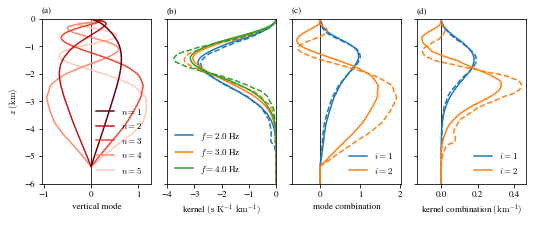

ECCO
(3, 5)
SVD:
[[-0.52850736 -0.81590565 -0.23447373]
 [-0.58702981  0.1517224   0.79522092]
 [-0.61325033  0.55792318 -0.55914734]]
[ 27.81367224   1.52399306   0.05872752]
[[ 0.84181619 -0.49623883 -0.03095837  0.17374423 -0.11809763]
 [-0.09892348 -0.33720131  0.87114564 -0.34235052 -0.02026864]]
SVDg:
[[-0.48499967 -0.83649247 -0.25506012]
 [-0.59559163  0.1023874   0.79673549]
 [-0.64034829  0.53832812 -0.54786577]]
[ 28.54461175   1.86322371   0.26818074]
[[ 0.82896325 -0.4950459   0.00418522  0.20179094 -0.16435447]
 [ 0.11098496 -0.2100809   0.58788872 -0.67218568  0.38223241]]
-1475.0
-2375.0


D:\ProgramData\Miniconda3\envs\obspy\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


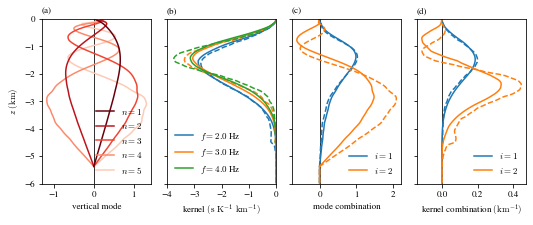

In [2]:
nmode = 5
Lx = 29e5
mu = 5e-5
colors = ["#1f78b4","#a6cee3","#33a02c","#b2df8a","#fb9a99"]
c3 = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
c2 = c3[:2]#["#67a9cf","#ef8a62"]
var = 'T'
dsK = xr.open_dataset('data/knl/KTs_Nias_H08_coarsen.nc')
dsKg = xr.open_dataset('data/knl/KTs_Nias_H08_Gaussian.nc').interp_like(dsK)
dx = np.diff(dsK.x)[0]
#fband = [1/15,1/10]
hncmap = mpl.cm.get_cmap("Reds_r")
lss = ['-','--']
spectra = False
N0 = 1e-3
if spectra:
    fig,ax = plt.subplots(1,2,figsize=(9.6,5.2))
for i,model in enumerate(['ofes','ecco']):
    print(model.upper())
    dsm = xr.open_dataset(f'results/{model}/modes_full_{model}.nc')
    idx = np.where((dsm.x>=0)&(dsm.x<=Lx))[0]
    dsn2 = xr.open_dataset(f'data/{model}/n2_Nias_H08_2005.nc').isel(x=idx)
    dx,dz = np.diff(dsK.x).mean(),np.diff(dsK.z).mean()
    #Ax = (dsK.SEMkernels_T*dsm.hn*dsn2.n2).sum(dim="z",skipna=True)*dx*dz/N0
    #Ax = Ax.isel(x=idx,n=slice(nmode)).values.reshape((3,-1))
    #u,s,vhx = np.linalg.svd(Ax)
    #u[:,1] *= -1
    #vhx[1,:] *= -1
    #vh = vhx[:2].reshape((2,-1,nmode)).sum(axis=1)
    #vh = vh/np.linalg.norm(vh,axis=1)[:,None]
    dsm = xr.open_dataset(f'results/{model}/modes_mean_{model}.nc').isel(n=slice(nmode))
    n2G = np.nan_to_num(np.nanmean(dsn2.n2.values,axis=0)[None,:]*dsm.hn.values)
    A = np.sum(dsK.SEMkernels_T.values,axis=1)@n2G.T*dx*dz/N0
    print(A.shape)
    u,s,vh = np.linalg.svd(A)
    Ag = np.sum(np.nan_to_num(dsKg.SEMkernels_T.values),axis=1)@n2G.T*dx*dz/N0
    ug,sg,vhg = np.linalg.svd(Ag)
    vh,vhg = vh[:2],vhg[:2]
    u *= -1
    vh *= -1
    ug *= -1
    vhg *= -1
    #vhg = vhxg[:2].reshape((2,-1,nmode)).sum(axis=1)
    #vhg = vhg/np.linalg.norm(vhg,axis=1)[:,None]
    print(f'SVD:\n{u}\n{s}\n{vh}')
    print(f'SVDg:\n{ug}\n{sg}\n{vhg}')
    
    #damp = ((dsm.hn*dsn2.n2)**2/dsm.cn**2/dsm.H).sum(dim="z",skipna=True).isel(x=idx).mean(dim="x",skipna=True)
    #damp = mu*damp.values*dz
    #print(f'damping scales (days): {1/damp[:nmode]/(24*3600)}')
    
    ncol = 4
    fig,ax = plt.subplots(1,ncol,figsize=(190/25.4,3.2),sharey=True)
    for j in range(3):
        ax[1].plot(1e3*dx*dsK.SEMkernels_T.sum(dim="x",skipna=True).isel(f=j),
                   1e-3*dsK.z,c=c3[j],label=f'$f={dsK.f[j].values:.1f}$ Hz')
        ax[1].plot(1e3*dx*dsKg.SEMkernels_T.sum(dim="x",skipna=True).isel(f=j),
                   1e-3*dsK.z,c=c3[j],ls='--')#,label=f'$f={dsK.f[j].values:.1f}$ Hz')
    ax[1].set_xlabel(r'kernel $(\mathrm{s}~\mathrm{K}^{-1}~\mathrm{km}^{-1})$')
    ax[1].set_xlim([-4,0])
    #ax[2].set_xlabel(r'kernel $(\mathrm{s}~\mathrm{K}^{-1}~\mathrm{km}^{-1})$')
    #ax[2].set_title(r'no sediment')
    ax[1].legend(loc=3, frameon=False)
    #ax[2].legend(loc=3, frameon=False)
    for j in range(2):
        ax[-1].plot((1e3*dx*u.T@dsK.SEMkernels_T.sum(dim="x",skipna=True).values)[j]/s[j],
                   1e-3*dsK.z,c=c2[j],label=f'$i= {j+1}$')
        k = np.argmax((1e3*dx*u.T@dsK.SEMkernels_T.sum(dim="x",skipna=True).values)[j])
        print(dsK.z.values[k])
        ax[-1].plot((1e3*dx*ug.T@dsKg.SEMkernels_T.sum(dim="x",skipna=True).values)[j]/sg[j],
                   1e-3*dsK.z,c=c2[j],ls='--')
    #ax[1].set_xlabel(r'$\mathbf{\Lambda}^{-1} \mathbf{U}^{\mathrm{T}}\mathbf{K}~(\mathrm{km}^{-1})$')
    ax[-1].set_xlabel(r'kernel combination $(\mathrm{km}^{-1})$')

    for j in range(nmode):
        ax[0].plot(dsm.hn.isel(n=j)*N0,
                   1e-3*dsm.z,c=hncmap(j*0.2),label=f'$n= {j+1}$',zorder=5-j)
    ax[0].set_xlabel(r'vertical mode')
    ax[0].legend(loc='lower right', frameon=False)
    for j in range(2):
        ax[-2].plot(N0*np.nansum((dsm.hn*vh[j][:,None]).T,axis=(-1)),
                  1e-3*dsm.z,c=c2[j],label=f'$i= {j+1}$')
        ax[-2].plot(N0*np.nansum((dsm.hn*vhg[j][:,None]).T,axis=(-1)),
                  1e-3*dsm.z,c=c2[j],ls='--')
    ax[-2].set_xlabel(r'mode combination')
    for j in range(ncol):
        ax[j].axvline(0, color="k", lw=0.8,zorder=0)
    ax[0].set_ylabel(r'$z~(\mathrm{km})$')
    ax[0].set_ylim([-6,0])
    ax[-1].legend(loc='lower right', frameon=False)
    ax[-2].legend(loc='lower right', frameon=False)
    for j in range(ncol):
        ax[j].set_title(f'({ast[j]})', loc="left")
    plt.tight_layout()
    #fig.savefig(f'results/{model}/kg_SVD.pdf', bbox_inches='tight')
    plt.show()
      
    if spectra:
        nsub = int(len(t)/2)
        idx3 = [[0,nsub],[nsub,2*nsub],[int(nsub/2),int(nsub/2)+nsub]]
        taui0m = (u.T@taui0)[:2]
        for j in range(2):
            sigm = taui0m[j]
            psd3 = []
            for k in range(3):
                i1,i2 = idx3[k]
                s = sigm[i1:i2]-np.nanmean(sigm[i1:i2])
                tmphan=np.hanning(len(s))
                PSD,FFT,om = make_FFT1D(tmphan*s,t[i1:i2],1)
                psd3.append(PSD)
            oidx = np.where(om>4e-2)
            psd3 = np.array(psd3)
            ax[j].semilogx(om[oidx],om[oidx]*psd3.mean(axis=0)[oidx],label=f'SVD with {model} $N^2 G_i$')
            ax[j].axvline(1/9, linestyle="--", color="k", alpha=0.2)
            ax[j].axvline(1/12, linestyle="--", color="k", alpha=0.2)
            ax[j].axvline(1/16, linestyle="--", color="k", alpha=0.2)
            ax[j].set_title(f'$T$-wave $c_{j+1}$')
            ax[j].set_ylabel(r'$f\cdot \mathrm{PSD}(T^\prime)$')
            ax[j].set_xlabel(r'$f$ (cpd)')
            ax[0].legend()
            
#SVD:
#[[-0.52661203 -0.81835759 -0.23015349]
# [-0.58738631  0.15456378  0.79441007]
# [-0.61453811  0.55353491 -0.56208719]]
#[ 27.12374829   1.46384981   0.06295741]
#[[ 0.84591688 -0.48926263 -0.02147013  0.1622701  -0.13510793]
# [-0.0942763  -0.32147954  0.88483974 -0.32004803  0.04889547]]
#SVDg:
#[[-0.48304356 -0.83755825 -0.25527454]
# [-0.59613033  0.10104334  0.79650416]
# [-0.64132484  0.5369231  -0.54810221]]
#[ 27.7820912    1.78801044   0.25561642]
#[[ 0.83361223 -0.48759875  0.01499772  0.18555715 -0.18078085]
# [ 0.10977901 -0.20029872  0.59544634 -0.6120094   0.46767204]]

ofes
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.57484484e-10   5.75226046e-11
   1.32457646e-09   3.25590192e-09   5.21803737e-09   4.49756512e-09
   3.38020898e-09   2.85222665e-09   3.66371750e-09   3.67799122e-09
   6.22975666e-09   5.67033888e-09   1.26286667e-08   2.03430499e-08
   2.02741105e-08   1.99860842e-08   1.87117261e-08   2.44608981e-08
   4.59297392e-08   6.22998869e-08   6.15211383e-08   6.15211383e-08
   6.13932357e-08   8.12215432e-08   1.07205717e-07   1.12952624e-07
   1.12437840e-07   1.11977972e-07   1.36010549e-07   1.90128029e-07
   2.21113753e-07   2.18907029e-07   2.18470959e-07   2.38832923e-07
   3.16947511e-07   3.71026775e-07   3.65736007e-07   3.62279145e-07
   3.73256214e-07   4.07126393e-07   4.27323961e-07   4.23316304e-07
   4.20415668e-07   4.6318893

D:\ProgramData\Miniconda3\envs\obspy\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == "":
D:\ProgramData\Miniconda3\envs\obspy\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
D:\ProgramData\Miniconda3\envs\obspy\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == "":


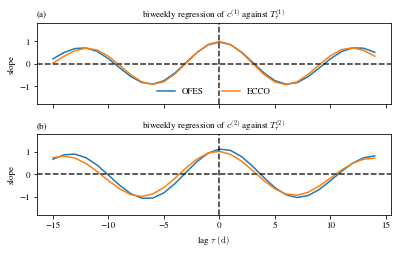

In [3]:
from scipy import signal
nmode = 5
var = 'T'
dsK = xr.open_dataset('data/knl/KTs_Nias_H08_coarsen.nc')
lband,uband = [1/17,1/15,1/12],[1/10,1/12,1/10]
fig,ax=plt.subplots(2,1,figsize=(5.6, 3.6),sharex=True)
fs = 1
for i,model in enumerate(['ofes','ecco']):
    print(model)
    dsn2 = xr.open_dataset(f'data/{model}/n2_Nias_H08_2005.nc').isel(x=idx)
    dsm = xr.open_dataset(f'results/{model}/modes_mean_{model}.nc').isel(n=slice(nmode))
    n2G = np.nan_to_num(np.nanmean(dsn2.n2.values,axis=0)[None,:]*dsm.hn.values)
    A = np.nan_to_num(np.nansum(dsK.SEMkernels_T.values,axis=1))@n2G.T*dx*dz/N0
    u,s,vh = np.linalg.svd(A)
    vh = vh[:2]
    #_,_,vh0 = np.linalg.svd(A)
    if model=='ofes':
        print(np.nan_to_num(np.nanmean(dsn2.n2.values,axis=0)))
    
    dsh = xr.open_dataset(f'results/{model}/hnd{var}_Nias_H08_2005.nc')
    #Tix = np.transpose(dsh.hndsig1.isel(x=idx,n=slice(nmode)).values,(1,2,0)).reshape((365,-1))
    Ti = dsh.hndsig1*N0#.isel(x=idx).mean(dim="x",skipna=True)
    t = dsh.t
    nsub = int(len(t)/2)
    idx3 = [[0,nsub],[nsub,2*nsub],[int(nsub/2),int(nsub/2)+nsub]]
    
    #taui0m = (u.T@taui0)[:2]  
    tauim = xr.open_dataset(f'results/{model}/kTdT_Nias_H08_2005_coarsen.nc')['SEMdtaus']
    tauim = (u.T@tauim.values/s[:,None])[:2]
    print(np.cov(tauim))
       
    Tibp = []
    print('Ti covariance:')
    for j in range(nmode):
        Tibp.append(Ti.isel(n=j).values)
    Tibp = np.array(Tibp)
    print(np.diag(Tibp@Tibp.T)/364)
    for j in range(2):
        ci3 = vh[j,:nmode][:,None]*Tibp
        print(np.diag(ci3@ci3.T)/364)
        
    #Tibp = vhx[:2]@Tix.T 
    Tibp = vh@Ti[:nmode].values
    for f in range(3):
        Tibpf = []
        for j in range(2):
            Tibpf.append(bandpass(signal.detrend(Tibp[j]-np.mean(Tibp[j])),
                                                 lband[f], uband[f],fs, 5, True))

        tauibp = []
        for j in range(2):
            tauibp.append(bandpass(signal.detrend(tauim[j]-np.mean(tauim[j])),
                                                  lband[f], uband[f],fs, 5, True))

        for j in range(2):
            coef = []
            for l in range(-15,15):
                x,y = Tibpf[j][None,:],tauibp[j]
                if l>0:
                    x,y = x[:,:-l],y[l:]
                elif l<0:
                    x,y = x[:,-l:],y[:l]

                coef.append(np.linalg.solve(x@x.T,x@y[:,None]))
            coef = np.array(coef)

            for k in range(1):
                if f==0:
                    ax[j].plot(np.arange(-15,15),coef[:,k],label=model.upper())

            ax[j].axhline(0, linestyle="--", color="k", alpha=0.2)
            ax[j].axvline(0, linestyle="--", color="k", alpha=0.2)
            unit = r'~(\mathrm{K}^{-1} \mathrm{km}^{-1})$'
            ax[j].set_ylabel(r'slope')
            ax[j].set_title(r'biweekly regression of $c^{('+f'{j+1}'+r')}$ against $T^{('+f'{j+1}'+r')}_{\tau}$')
    ax[-1].set_xlabel(r'lag $\tau~(\mathrm{d})$')
    for j in range(2):
        ax[j].set_title(f'({ast[j]})', loc="left")
ax[0].set_ylim([-1.8,1.8])
ax[-1].set_ylim([-1.8,1.8])
ax[0].legend(ncol=3,loc='lower center',frameon=False)
plt.tight_layout()
fig.align_ylabels()
#fig.savefig(f'results/ofes/ciTi_regression.pdf',dpi=300)
plt.show()

D:\ProgramData\Miniconda3\envs\obspy\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == "":
D:\ProgramData\Miniconda3\envs\obspy\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == "":


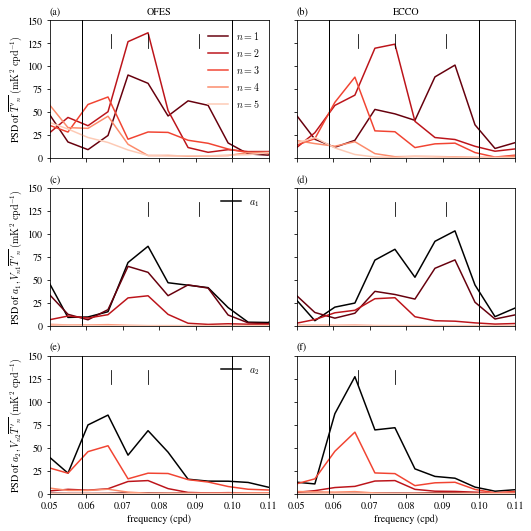

In [6]:
plt.rcParams.update({"font.size": 10})
from scipy.stats import chi2
#colors = ["#1f78b4","#a6cee3","#33a02c","#b2df8a"]
df,alpha,ci = 3*36/19,1-0.95,[]
for y in [1-alpha/2,alpha/2]:
    ci.append(df/chi2.ppf(y, df))
vsu2,vhx2 = [],[]
figs, axs = plt.subplots(3, 2, figsize=(190/25.4, 190/25.4), sharex=True,sharey='row')
for i,model in enumerate(['ofes','ecco']):
    dsn2 = xr.open_dataset(f'data/{model}/n2_Nias_H08_2005.nc')
    dsm = xr.open_dataset(f'results/{model}/modes_mean_{model}.nc').isel(n=slice(nmode))
    n2G = np.nan_to_num(np.nanmean(dsn2.n2.values,axis=0)[None,:]*dsm.hn.values)
    A = np.nan_to_num(np.nanmean(dsK.SEMkernels_T.values,axis=1))@n2G.T*Lx*dz/N0
    u,s,vh = np.linalg.svd(A)
    vh = vh[:2]
    dsh = xr.open_dataset(f'results/{model}/hnd{var}_Nias_H08_2005.nc')
    Ti = dsh.hndsig1*N0
    t = dsh.t
    nsub = int(len(t)/2)
    idx3 = [[0,nsub],[nsub,2*nsub],[int(nsub/2),int(nsub/2)+nsub]]
    for j in range(nmode):
        sigm = signal.detrend(Ti[j]-np.mean(Ti[j]))
        psd3 = []
        for l in range(3):
            i1,i2 = idx3[l]
            s = sigm[i1:i2]
            tmphan=np.hanning(len(s))
            PSD,FFT,om = make_FFT1D(np.sqrt(8/3)*tmphan*s,t.values[i1:i2],1)
            psd3.append(PSD)
        oidx = np.where(om>2e-2)
        psd3 = np.array(psd3)
        axs[0,i].plot(om[oidx],1e6*psd3.mean(axis=0)[oidx],
                        color = hncmap(j*0.2),label=f'$n= {j+1}$')
        #axs[0,i].axvline(1/9.5, linestyle="--", color="k", alpha=0.2)
        #axs[0,i].axvline(1/18, linestyle="--", color="k", alpha=0.2)
        for fb in [10,17]:#[4.5,5.5,7.5,12,26]: 
            axs[0,i].axvline(1/fb,c='k',lw=.8)
    axs[0,i].set_title(f"{model.upper()}")
    
    for j in range(2):
        axs[2,j].set_xlabel(r"frequency (cpd)")
        axs[2,j].set_xlim([1/20,0.11])
    
    for k in range(2):
        sigm = vh[k]@Ti[:nmode].values
        sigm = signal.detrend(sigm-np.nanmean(sigm))
        psd3 = []
        for l in range(3):
            i1,i2 = idx3[l]
            s = sigm[i1:i2]#-np.nanmean(sigm[i1:i2])
            tmphan=np.hanning(len(s))
            PSD,FFT,om = make_FFT1D(np.sqrt(8/3)*tmphan*s,t.values[i1:i2],1)
            psd3.append(PSD)
        oidx = np.where(om>2e-2)
        psd3 = np.array(psd3)
        axs[k+1,i].plot(om[oidx],1e6*psd3.mean(axis=0)[oidx],color = 'k',label=f'$a_{k+1}$')
            
    for j in range(nmode):
        for k in range(2):
            sigm = vh[k,j]*Ti[j].values
            sigm = signal.detrend(sigm-np.nanmean(sigm))
            psd3 = []
            for l in range(3):
                i1,i2 = idx3[l]
                s = sigm[i1:i2]#-np.nanmean(sigm[i1:i2])
                tmphan=np.hanning(len(s))
                PSD,FFT,om = make_FFT1D(np.sqrt(8/3)*tmphan*s,t.values[i1:i2],1)
                psd3.append(PSD)
            oidx = np.where(om>2e-2)
            psd3 = np.array(psd3)
            axs[k+1,i].plot(om[oidx],1e6*psd3.mean(axis=0)[oidx],color = hncmap(j*0.2))
            #axs[k+1,i].axvline(1/9.5, linestyle="--", color="k", alpha=0.2)
            #axs[k+1,i].axvline(1/18, linestyle="--", color="k", alpha=0.2)
            for fb in [10,17]:#[4.5,5.5,7.5,12,26]: 
                axs[k+1,i].axvline(1/fb,c='k',lw=.8)
            #axs[k+1,i].axvline(1/14,c='k',ls=':',alpha=0.2)

    for j in range(3):
        axs[j,i].set_title(f'({ast[i+2*j]})', loc="left")
        axs[j,0].set_ylim([0,150])
axs[0,0].legend(loc="upper right",frameon=False)
yerr = .5*np.array([1-ci[0],ci[1]-1])[:,None]
#axs[0,0].errorbar(6.3e-2, .5, yerr, fmt='.',capsize=2)
#axs[0,0].text(6.5e-2, .3, r"$95 \%$",c='k')
axs[1,0].legend(loc="upper right",frameon=False)
axs[2,0].legend(loc="upper right",frameon=False)
axs[0,0].set_ylabel(r"PSD of $\overline{T'_n}~(\mathrm{mK}^2~\mathrm{cpd}^{-1})$")
axs[1,0].set_ylabel(r"PSD of $a_1,V_{n1}\overline{T'_n}~(\mathrm{mK}^2~\mathrm{cpd}^{-1})$")
axs[2,0].set_ylabel(r"PSD of $a_2,V_{n2}\overline{T'_n}~(\mathrm{mK}^2~\mathrm{cpd}^{-1})$")
for i in range(2):
    axs[0,i].axvline(1/11,c='k',lw=0.8,ymin=0.8,ymax=0.9)
    axs[1,i].axvline(1/11,c='k',lw=0.8,ymin=0.8,ymax=0.9)
    for j in range(3):
        axs[j,i].axvline(1/13,c='k',lw=0.8,ymin=0.8,ymax=0.9)
    axs[0,i].axvline(1/15,c='k',lw=0.8,ymin=0.8,ymax=0.9)
    axs[2,i].axvline(1/15,c='k',lw=0.8,ymin=0.8,ymax=0.9)
plt.tight_layout()
figs.savefig(f'results/ofes/spectra_modes.pdf', bbox_inches='tight')
plt.show()

1/17-1/10 cpd
1/17-1/10 cpd


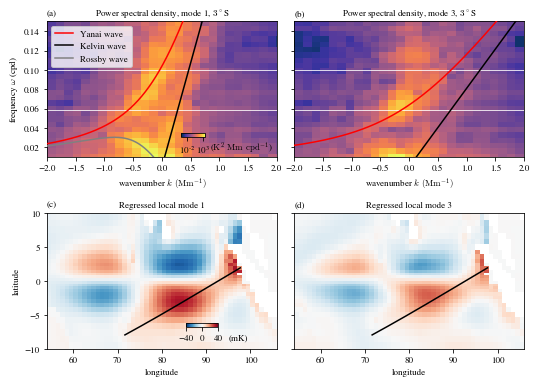

In [5]:
import cmocean
import warnings
from scipy import signal
import matplotlib.colors as mc
warnings.filterwarnings("ignore")
cmap = cmocean.cm.thermal
def make_FFT2D(field,t,dt,x,dx):
    signal=field[:,::-1]
    FFT=np.fft.fftshift(np.fft.rfft2(signal,signal.shape),axes=0)
    freq=np.fft.rfftfreq(len(t),dt)
    k = np.fft.fftshift(np.fft.fftfreq(len(x),dx))

    ###ATTENTION, FFTFREQ RETOURNE UNE FREQUENCE DONC 1/DX
    FFT=FFT/np.sqrt(signal.shape[0]*signal.shape[1])
    PSD=np.real(FFT*np.conj(FFT))

    return PSD,freq,k

model = 'ecco'
plot = 'bw'
beta = 2.3e-11*1e6*86400
f0 = 14.6e-5*np.sin(3/180*np.pi)

fig,axs = plt.subplots(2,2,figsize=(190/25.4,5.4),sharey="row")

ds = xr.open_dataset(f"results/{model}/hndT_{model}_3S.nc")
f = h5py.File('results/ecco/G_nias_05.h5', 'r')
x = np.array(f['x'])
H = np.array(f['H'])
nsub = int(len(ds.t)/2)
idx3 = [[0,nsub],[nsub,2*nsub],[int(nsub/2),int(nsub/2)+nsub]]
xidx = np.where(~(H==0))[0]
dt,dx = 1,(ds.x[1]-ds.x[0]).values*6.371/180*np.pi
wt,wx = np.hanning(nsub),np.hanning(len(xidx))
w2d = wx.reshape((-1,1))*wt.reshape((1,-1))
im0 = []
for i in range(2):
    ax = axs[0,i]
    λ = np.array(f['λ'])[i*2]
    psd3 = []
    for j in range(3):
        i1,i2 = idx3[j]
        sig=signal.detrend(ds.hndT.isel(n=i*2,t=slice(i1,i2),x=xidx).values.T)
        PSD,freq,k = make_FFT2D(w2d*sig,
                                ds.t.values[i1:i2],dt,
                                ds.x.values[xidx],dx)
        psd3.append(PSD)
    psd3 = np.array(psd3)

    if plot=='full':
        fidx = np.where(freq>1e-2)[0]
    else:
        fidx = np.where((freq>0.01)&(freq<0.2))[0]
    kidx = np.where(np.abs(k)<2.5)[0]
    freq,k = freq[fidx],k[kidx] 

    c = np.sum(f0*λ[xidx]*wx)/np.sum(wx)/1e6*86400

    # dispersion curves
    yanai = lambda omega : -beta/omega+omega/c
    kelvin = lambda omega : omega/c
    rgp = lambda omega,m : np.where((beta/omega-2*omega/c)**2 < 8*m*beta/c,np.nan,-beta/(2*omega) + 1/2*np.sqrt((beta/omega-2*omega/c)**2 - 8*m*beta/c))
    rgm = lambda omega,m : np.where((beta/omega-2*omega/c)**2 < 8*m*beta/c,np.nan,-beta/(2*omega) - 1/2*np.sqrt((beta/omega-2*omega/c)**2 - 8*m*beta/c))              

    fw = np.linspace(0,0.3,int(1e5))
    ky = yanai(2*np.pi*fw)/(2*np.pi)
    kk = kelvin(2*np.pi*fw)/(2*np.pi)
    kr = rgp(2*np.pi*fw,np.arange(1,5).reshape(-1,1))/(2*np.pi)
    kg = rgm(2*np.pi*fw,np.arange(1,5).reshape(-1,1))/(2*np.pi)
    Z = psd3.mean(axis=0)[kidx][:,fidx].T
    im0.append(ax.pcolormesh(k,freq,Z, cmap=cmap,
                             norm=mc.LogNorm(vmin=Z.min(), vmax=Z.max()),
                             rasterized=True,shading='nearest'))
    ax.plot(ky,fw,c='r',label='Yanai wave',zorder=3)
    ax.plot(kk,fw,c='k',label='Kelvin wave',zorder=3)
    if i<1:
        ax.plot(kr[0],fw,c='gray',label='Rossby wave',zorder=3)
        ax.plot(kg[0],fw,c='gray',zorder=3)

    ax.set_ylim([0.01,0.15])

    ax.set_xlim([-2,2])
    ax.set_xlabel(r'wavenumber $k\ (\mathrm{Mm}^{-1})$')
    ax.set_title(f'Power spectral density, mode {2*i+1}, $3^\circ$S')
    ax.set_title(f'({ast[int(i)]})', loc="left")
    ax.axhline(1/10,c='w',lw=0.8,zorder=1)
    ax.axhline(1/17,c='w',lw=0.8,zorder=1)

axs[0,0].set_ylabel(r'frequency $\omega$ (cpd)')
axs[0,0].legend(loc='upper left')

model,arg = 'ecco','_Omodes'
nrow = 2
ds = xr.open_dataset(f'results/{model}/regression_T{arg}.nc')
lowcuts,highcuts = ds.lowcuts.values,ds.highcuts.values
l,m=15,0
im = []
for n in range(2):
    axs[-1,n].set_xlabel(r'longitude')
    im.append(axs[-1,n].pcolormesh(ds.lon,ds.lat,ds.c.isel(i=n,fband=m,lag=l).T,
                                   vmin=-40,vmax=40,cmap='RdBu_r',rasterized=True,shading='auto'))
    axs[-1,n].plot(lon_k,lat_k,c='k')
    axs[-1,n].set_ylim([-10,10])
    bands = f'1/{1/lowcuts[m]:.0f}-1/{1/highcuts[m]:.0f} cpd'
    print(bands)
    axs[-1,n].set_title(f'Regressed local mode {2*n+1}')
   # axs[-1,n].axhline(0, linestyle=":", color="k", lw=1)
    axs[-1,n].set_title(f'({ast[2+n]})', loc="left")
axs[-1,0].set_ylabel(r'latitude')
plt.tight_layout()
cbaxes = fig.add_axes([0.34, 0.64, 0.045, 0.01]) 
cbaxes.text(130000, 1e-30,r'($\mathrm{K}^2~\mathrm{Mm}~\mathrm{cpd}^{-1}$)')
cbar = fig.colorbar(im0[0], cax=cbaxes, ticks=[.01,1000], orientation='horizontal')
cbaxes = fig.add_axes([0.35, 0.15, 0.06, 0.01]) 
cbaxes.text(65, -290,r'(mK)')
cbar = fig.colorbar(im[0], cax=cbaxes, ticks=[-40,0,40], orientation='horizontal')
#plt.savefig(f'results/{model}/fk_mode1a3_regressedG.pdf', bbox_inches='tight')
plt.show()

In [8]:
beta = 2.3e-11*1e6*86400
f0 = 14.6e-5*np.sin(3/180*np.pi)
ds = xr.open_dataset(f"results/{model}/hndT_{model}_3S.nc")
f = h5py.File('results/ecco/G_nias_05.h5', 'r')
x = np.array(f['x'])
H = np.array(f['H'])
xidx = np.where(~(H==0))[0]
fws = np.array([1/11,1/13,1/15,1/17])
for i in range(3):
    λ = np.array(f['λ'])[i]

    #c = np.sum(f0*λ[xidx])/1e6*86400
    c = np.mean(f0*λ[xidx])/1e6*86400
    
    print(2*np.pi/np.sqrt(c*beta))
    # dispersion curves
    yanai = lambda omega : -beta/omega+omega/c
    
    ky = yanai(2*np.pi*fws)/(2*np.pi)
    print(1/ky)

9.62095168159
[-7.68462458 -3.37875138 -2.2500861  -1.71926629]
12.2119129895
[  7.76834436 -12.99814991  -3.92775166  -2.41459917]
15.7958681849
[  1.70049662   3.20785435  12.15838304  -8.55212256]


1/17-1/10 cpd
1/17-1/10 cpd


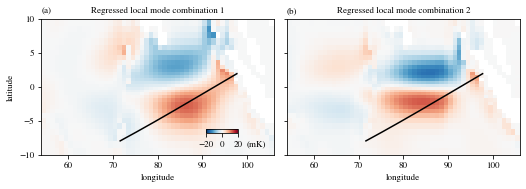

In [4]:
model = 'ecco'
plot = 'bw'
beta = 2.3e-11*1e6*86400
f0 = 14.6e-5*np.sin(3/180*np.pi)

fig,axs = plt.subplots(1,2,figsize=(190/25.4,2.7),sharey="row")

ds = xr.open_dataset(f"results/{model}/hndT_{model}_3S.nc")
f = h5py.File('results/ecco/G_nias_05.h5', 'r')
x = np.array(f['x'])
H = np.array(f['H'])
nsub = int(len(ds.t)/2)
idx3 = [[0,nsub],[nsub,2*nsub],[int(nsub/2),int(nsub/2)+nsub]]
xidx = np.where(~(H==0))[0]
dt,dx = 1,(ds.x[1]-ds.x[0]).values*6.371/180*np.pi
wt,wx = np.hanning(nsub),np.hanning(len(xidx))
w2d = wx.reshape((-1,1))*wt.reshape((1,-1))

model,arg = 'ecco','_5modes'
nrow = 2
ds = xr.open_dataset(f'results/{model}/regression_T{arg}.nc')
lowcuts,highcuts = ds.lowcuts.values,ds.highcuts.values
l,m=15,0
for n in range(2):
    axs[n].set_xlabel(r'longitude')
    im = axs[n].pcolormesh(ds.lon,ds.lat,-ds.c.isel(i=n,fband=m,lag=l).T,
                            vmin=-20,vmax=20,cmap='RdBu_r',rasterized=True,shading='auto')
    axs[n].plot(lon_k,lat_k,c='k')
    axs[n].set_ylim([-10,10])
    bands = f'1/{1/lowcuts[m]:.0f}-1/{1/highcuts[m]:.0f} cpd'
    print(bands)
    axs[n].set_title(f'Regressed local mode combination {n+1}')
   # axs[-1,n].axhline(0, linestyle=":", color="k", lw=1)
    axs[n].set_title(f'({ast[n]})', loc="left")
axs[0].set_ylabel(r'latitude')
plt.tight_layout()
cbaxes = fig.add_axes([0.40, 0.30, 0.06, 0.02]) 
cbaxes.text(30, -150,r'(mK)')
cbar = fig.colorbar(im, cax=cbaxes, ticks=[-20,0,20], orientation='horizontal')
plt.savefig(f'results/{model}/regressedTl.pdf', bbox_inches='tight')
plt.show()

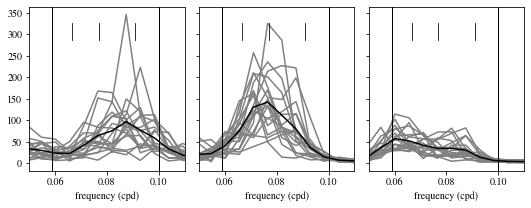

In [4]:
plt.rcParams.update({"font.size": 10})
from scipy.stats import chi2
#colors = ["#1f78b4","#a6cee3","#33a02c","#b2df8a"]
df,alpha,ci = 3*36/19,1-0.95,[]
for y in [1-alpha/2,alpha/2]:
    ci.append(df/chi2.ppf(y, df))
vsu2,vhx2 = [],[]
figs, axs = plt.subplots(1, 3, figsize=(190/25.4, 190/25.4/2.5),sharey='row')
for i,model in enumerate(['ecco']):
    dsh = xr.open_dataset(f'results/{model}/hnd{var}_Nias_H08_0017.nc')
    for j in range(3):
        psdj = []
        for n in range(2000,2018):
            t0,t1 = np.datetime64(f'{n}-01-01'),np.datetime64(f'{n+1}-01-01')
            Ti = dsh.hndsig1.sel(t=slice(t0,t1))[j]*N0
            t = Ti.t
            nsub = 183#int(len(t)/2)
            idx3 = [[0,nsub],[len(t)-nsub,len(t)],[int(len(t)/4),int(len(t)/4)+nsub]]
            sigm = signal.detrend(Ti-np.mean(Ti))
            psd3 = []
            for l in range(3):
                i1,i2 = idx3[l]
                s = sigm[i1:i2]
                tmphan=np.hanning(len(s))
                PSD,FFT,om = make_FFT1D(np.sqrt(8/3)*tmphan*s,t.values[i1:i2],1)
                psd3.append(PSD)
            oidx = np.where(om>2e-2)
            psd3 = np.array(psd3)
            psdj.append(1e6*psd3.mean(axis=0))
            axs[j].plot(om[oidx],1e6*psd3.mean(axis=0)[oidx],
                            color = 'grey')
            for fb in [10,17]:#[4.5,5.5,7.5,12,26]: 
                axs[j].axvline(1/fb,c='k',lw=.8)
            axs[j].set_xlabel(r"frequency (cpd)")
            axs[j].set_xlim([1/20,0.11])
        axs[j].plot(om[oidx],np.array(psdj).mean(axis=0)[oidx],
                            color = 'k')
        axs[j].axvline(1/11,c='k',lw=0.8,ymin=0.8,ymax=0.9)
        axs[j].axvline(1/13,c='k',lw=0.8,ymin=0.8,ymax=0.9)
        axs[j].axvline(1/15,c='k',lw=0.8,ymin=0.8,ymax=0.9)

plt.tight_layout()
plt.savefig(f'results/ecco/mode123_0017.pdf', bbox_inches='tight')
plt.show()

D:\ProgramData\Miniconda3\envs\obspy\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


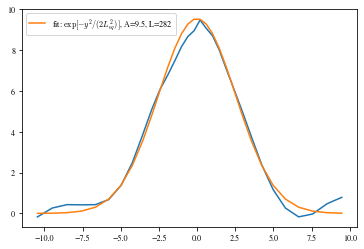

A=9.5, L=282


In [27]:
from scipy.optimize import curve_fit
def func(x, A, lnL):
    L = np.exp(lnL)
    return A**2*np.exp(-x**2/(2*L**2))

model,arg = 'ecco','_4modes_6bands'
nrow = 3
beta = 2.3e-11
lnL0 = np.log(1e-3*np.sqrt(2/beta))
ds = xr.open_dataset(f'results/{model}/regression_T{arg}.nc')
ds = ds = ds.sel(lon=slice(82,89),i=1,lag=-2,fband=1).mean(dim='lon')
#ds.sel(lon=slice(85,89),i=1,lag=0,fband=1).mean(dim='lon')
popt, pcov = curve_fit(func, np.deg2rad(ds.lat)*6371,ds.c,p0=[3.2,lnL0])
fig,ax=plt.subplots()
ax.plot(ds.lat,ds.c)
ax.plot(ds.lat, func(np.deg2rad(ds.lat)*6371, *popt),
         label=f'fit: $\exp[-y^2/(2L_{{eq}}^2)]$, A={popt[0]**2:.1f}, L={np.exp(popt[1]):.0f}')
ax.legend()
plt.show()
print(f'A={popt[0]**2:.1f}, L={np.exp(popt[1]):.0f}')
# 343.25246739, 273.20680036, 211.05753617, 179.58213637

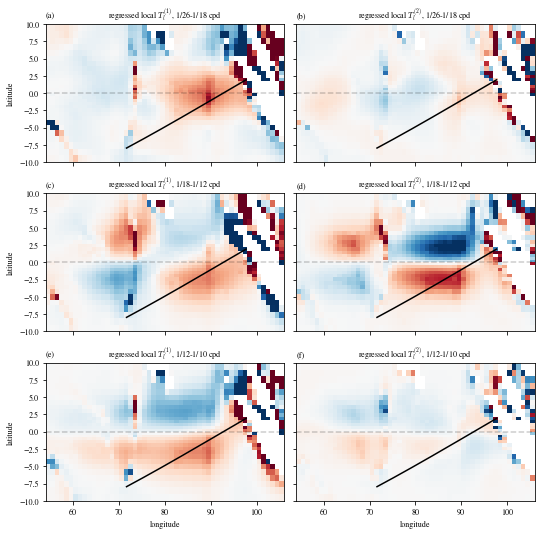

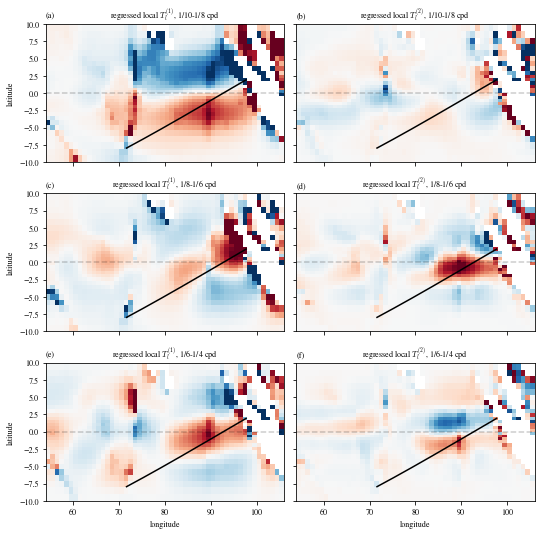

In [4]:
model,arg = 'ecco','_4modes_6bands'
nrow = 3
ds = xr.open_dataset(f'results/{model}/regression_T{arg}.nc')
lowcuts,highcuts = ds.lowcuts.values,ds.highcuts.values
for l in [15]:
    fig,ax = plt.subplots(nrow,2,figsize=(190/25.4, 190/25.4),sharex=True,sharey=True)
    #fig.suptitle(f'lag = {ds.lag.values[l]} day(s)')
    for n in range(2):
        ax[-1,n].set_xlabel(r'longitude')
        for m in range(3):
            ax[m,0].set_ylabel(r'latitude')
            im = ax[m,n].pcolormesh(ds.lon,ds.lat,ds.c.isel(i=n,fband=m,lag=l).T,
                                    vmin=-20,vmax=20,cmap='RdBu_r',rasterized=True,shading='auto')
            ax[m,n].plot(lon_k,lat_k,c='k')
            ax[m,n].set_ylim([-10,10])
            bands = f'1/{1/lowcuts[m]:.0f}-1/{1/highcuts[m]:.0f} cpd'
            ax[m,n].set_title(r'regressed local $T_l^{('+f'{n+1}'+r')}$, '+bands)
            ax[m,n].axhline(0, linestyle="--", color="k", alpha=0.2)
            ax[m,n].set_title(f'({ast[2*m+n]})', loc="left")
    fig.tight_layout()
    fig.savefig(f'results/{model}/regressionmap_lag{l-15}d_fbands1.pdf', bbox_inches='tight')
    plt.show()
    
    fig,ax = plt.subplots(nrow,2,figsize=(190/25.4, 190/25.4),sharex=True,sharey=True)
    #fig.suptitle(f'lag = {ds.lag.values[l]} day(s)')
    for n in range(2):
        ax[-1,n].set_xlabel(r'longitude')
        for m in range(3):
            ax[m,0].set_ylabel(r'latitude')
            im = ax[m,n].pcolormesh(ds.lon,ds.lat,ds.c.isel(i=n,fband=m+3,lag=l).T,
                                    vmin=-10,vmax=10,cmap='RdBu_r',rasterized=True,shading='auto')
            ax[m,n].plot(lon_k,lat_k,c='k')
            ax[m,n].set_ylim([-10,10])
            bands = f'1/{1/lowcuts[m+3]:.0f}-1/{1/highcuts[m+3]:.0f} cpd'
            ax[m,n].set_title(r'regressed local $T_l^{('+f'{n+1}'+r')}$, '+bands)
            ax[m,n].axhline(0, linestyle="--", color="k", alpha=0.2)
            ax[m,n].set_title(f'({ast[2*m+n]})', loc="left")
    fig.tight_layout()
    #fig.savefig(f'results/{model}/regressionmap_lag{l-15}d_fbands2.pdf', bbox_inches='tight')
    plt.show()

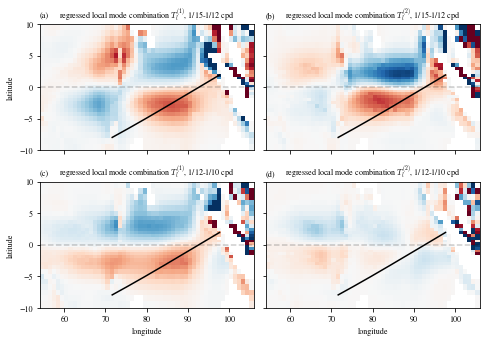

In [13]:
model,arg = 'ecco','_4modes'
nrow = 2
ds = xr.open_dataset(f'results/{model}/regression_T{arg}.nc')
lowcuts,highcuts = ds.lowcuts.values,ds.highcuts.values
for l in [15]:
    fig,ax = plt.subplots(nrow,2,figsize=(6.8, 4.8),sharex=True,sharey=True)
    #fig.suptitle(f'lag = {ds.lag.values[l]} day(s)')
    for n in range(2):
        ax[-1,n].set_xlabel(r'longitude')
        for m in range(2):
            ax[m,0].set_ylabel(r'latitude')
            im = ax[m,n].pcolormesh(ds.lon,ds.lat,ds.c.isel(i=n,fband=m+1,lag=l).T,
                                    vmin=-15,vmax=15,cmap='RdBu_r',rasterized=True,shading='auto')
            ax[m,n].plot(lon_k,lat_k,c='k')
            ax[m,n].set_ylim([-10,10])
            bands = f'1/{1/lowcuts[m+1]:.0f}-1/{1/highcuts[m+1]:.0f} cpd'
            ax[m,n].set_title(r'regressed local mode combination $T_l^{('+f'{n+1}'+r')}$, '+bands)
            ax[m,n].axhline(0, linestyle="--", color="k", alpha=0.2)
            ax[m,n].set_title(f'({ast[2*m+n]})', loc="left")
    fig.tight_layout()
    fig.savefig(f'results/{model}/regressionmap_lag{l-15}d_{model}.pdf', bbox_inches='tight')
    plt.show()

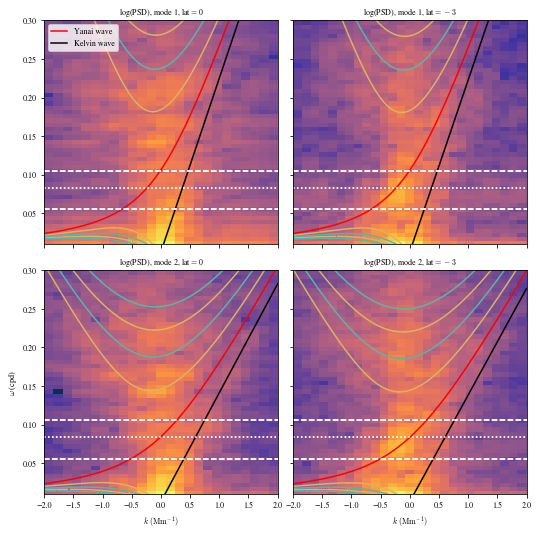

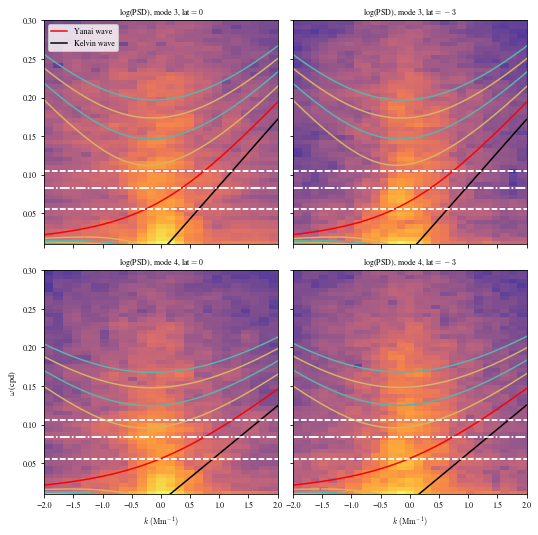

In [7]:
import cmocean
import warnings
warnings.filterwarnings("ignore")
cmap = cmocean.cm.thermal
def make_FFT2D(field,t,dt,x,dx):
    signal=field[:,::-1]
    FFT=np.fft.fftshift(np.fft.rfft2(signal,signal.shape),axes=0)
    freq=np.fft.rfftfreq(len(t),dt)
    k = np.fft.fftshift(np.fft.fftfreq(len(x),dx))

    ###ATTENTION, FFTFREQ RETOURNE UNE FREQUENCE DONC 1/DX
    FFT=FFT/np.sqrt(signal.shape[0]*signal.shape[1])
    PSD=np.real(FFT*np.conj(FFT))

    return PSD,freq,k

model = 'ecco'
plot = 'full'
beta = 2.3e-11*1e6*86400
fig,axs = plt.subplots(2,2,figsize=(190/25.4, 190/25.4),sharex=True,sharey=True)
for n,lat in enumerate([0,-3]):
    ds = xr.open_dataset(f"results/{model}/hndT_{model}_{lat:.0f}lat.nc")
    dsm = xr.open_dataset(f"results/{model}/modes_full_{model}_{lat:.0f}lat.nc")
    nsub = int(len(ds.t)/2)
    idx3 = [[0,nsub],[nsub,2*nsub],[int(nsub/2),int(nsub/2)+nsub]]
    xidx = np.where(~np.isnan(dsm.H))[0]
    dt,dx = 1,(ds.x[1]-ds.x[0]).values/1e6
    wt,wx = np.hanning(nsub),np.hanning(len(xidx))
    w2d = wx.reshape((-1,1))*wt.reshape((1,-1))
    for i in range(2):
        psd3 = []
        for j in range(3):
            i1,i2 = idx3[j]
            signal=ds.hndT.isel(n=i,t=slice(i1,i2),x=xidx).values.T
            PSD,freq,k = make_FFT2D(w2d*signal,
                                    ds.t.values[i1:i2],dt,
                                    ds.x.values[xidx],dx)
            psd3.append(PSD)
        psd3 = np.array(psd3)

        if plot=='full':
            fidx = np.where(freq>1e-2)[0]
        else:
            fidx = np.where((freq>0.06)&(freq<0.12))[0]
        kidx = np.where(np.abs(k)<2.5)[0]
        freq,k = freq[fidx],k[kidx] 

        c = np.sum(dsm.cn.isel(n=i,x=xidx).values*wx)/np.sum(wx)/1e6*86400

        # dispersion curves
        yanai = lambda omega : -beta/omega+omega/c
        kelvin = lambda omega : omega/c
        rgp = lambda omega,m : np.where((beta/omega-2*omega/c)**2 < 8*m*beta/c,np.nan,-beta/(2*omega) + 1/2*np.sqrt((beta/omega-2*omega/c)**2 - 8*m*beta/c))
        rgm = lambda omega,m : np.where((beta/omega-2*omega/c)**2 < 8*m*beta/c,np.nan,-beta/(2*omega) - 1/2*np.sqrt((beta/omega-2*omega/c)**2 - 8*m*beta/c))              

        fw = np.linspace(0,0.3,int(1e5))
        ky = yanai(2*np.pi*fw)/(2*np.pi)
        kk = kelvin(2*np.pi*fw)/(2*np.pi)
        kr = rgp(2*np.pi*fw,np.arange(1,5).reshape(-1,1))/(2*np.pi)
        kg = rgm(2*np.pi*fw,np.arange(1,5).reshape(-1,1))/(2*np.pi)

        axs[i,n].pcolormesh(k,freq,np.log(psd3.mean(axis=0))[kidx][:,fidx].T,
                            cmap=cmap,rasterized=True,shading='nearest')
        axs[i,n].plot(ky,fw,c='r',label='Yanai wave')
        axs[i,n].plot(kk,fw,c='k',label='Kelvin wave')
        axs[i,n].plot(kr[::2].T,fw,kg[::2].T,fw,c='#d8b365')
        axs[i,n].plot(kr[1::2].T,fw,kg[1::2].T,fw,c='#5ab4ac')

        if plot=='full':
            for j in range(2):
                axs[j,n].set_ylim([0.01,0.3])
        else:
            for j in range(2):
                axs[j,n].set_ylim([0.06,0.11])

        axs[1,n].set_xlim([-2,2])
        axs[1,n].set_xlabel(r'$k\ (\mathrm{Mm}^{-1})$')
        axs[i,n].set_title(f'log(PSD), mode {i+1}, lat$={lat:.0f}$')
        for j in range(2):
            #axs[j,n].axhline(0.1,c='w',ls=':')
            #axs[j,n].axhline(1/15,c='w',ls=':')
            #axs[j,n].axhline(1/4.5,c='w',ls=':')
            #axs[j,n].axhline(1/5.5,c='w',ls=':')
            #axs[j,n].axhline(1/7.5,c='w',ls=':')
            axs[j,n].axhline(1/9.5,c='w',ls='--')
            axs[j,n].axhline(1/12,c='w',ls=':')
            axs[j,n].axhline(1/18,c='w',ls='--')
            #axs[j,n].axhline(1/26,c='w',ls=':')
for i in range(2):
    axs[j,0].set_ylabel(r'$\omega$ (cpd)')
axs[0,0].legend(loc='upper left')
plt.tight_layout()
plt.savefig('results/'+model+'/fk_modes12.pdf', bbox_inches='tight')
plt.show()

fig,axs = plt.subplots(2,2,figsize=(190/25.4, 190/25.4),sharex=True,sharey=True)
for n,lat in enumerate([0,-3]):
    ds = xr.open_dataset(f"results/{model}/hndT_{model}_{lat:.0f}lat.nc")
    dsm = xr.open_dataset(f"results/{model}/modes_full_{model}_{lat:.0f}lat.nc")
    nsub = int(len(ds.t)/2)
    idx3 = [[0,nsub],[nsub,2*nsub],[int(nsub/2),int(nsub/2)+nsub]]
    xidx = np.where(~np.isnan(dsm.H))[0]
    dt,dx = 1,(ds.x[1]-ds.x[0]).values/1e6
    wt,wx = np.hanning(nsub),np.hanning(len(xidx))
    w2d = wx.reshape((-1,1))*wt.reshape((1,-1))
    for i in range(2):
        psd3 = []
        for j in range(3):
            i1,i2 = idx3[j]
            signal=ds.hndT.isel(n=i+2,t=slice(i1,i2),x=xidx).values.T
            PSD,freq,k = make_FFT2D(w2d*signal,
                                    ds.t.values[i1:i2],dt,
                                    ds.x.values[xidx],dx)
            psd3.append(PSD)
        psd3 = np.array(psd3)

        if plot=='full':
            fidx = np.where(freq>1e-2)[0]
        else:
            fidx = np.where((freq>0.06)&(freq<0.12))[0]
        kidx = np.where(np.abs(k)<2.5)[0]
        freq,k = freq[fidx],k[kidx] 

        c = np.sum(dsm.cn.isel(n=i+2,x=xidx).values*wx)/np.sum(wx)/1e6*86400

        # dispersion curves
        yanai = lambda omega : -beta/omega+omega/c
        kelvin = lambda omega : omega/c
        rgp = lambda omega,m : np.where((beta/omega-2*omega/c)**2 < 8*m*beta/c,np.nan,-beta/(2*omega) + 1/2*np.sqrt((beta/omega-2*omega/c)**2 - 8*m*beta/c))
        rgm = lambda omega,m : np.where((beta/omega-2*omega/c)**2 < 8*m*beta/c,np.nan,-beta/(2*omega) - 1/2*np.sqrt((beta/omega-2*omega/c)**2 - 8*m*beta/c))              

        fw = np.linspace(0,0.3,int(1e5))
        ky = yanai(2*np.pi*fw)/(2*np.pi)
        kk = kelvin(2*np.pi*fw)/(2*np.pi)
        kr = rgp(2*np.pi*fw,np.arange(1,5).reshape(-1,1))/(2*np.pi)
        kg = rgm(2*np.pi*fw,np.arange(1,5).reshape(-1,1))/(2*np.pi)

        axs[i,n].pcolormesh(k,freq,np.log(psd3.mean(axis=0))[kidx][:,fidx].T,
                            cmap=cmap,rasterized=True,shading='nearest')
        axs[i,n].plot(ky,fw,c='r',label='Yanai wave')
        axs[i,n].plot(kk,fw,c='k',label='Kelvin wave')
        axs[i,n].plot(kr[::2].T,fw,kg[::2].T,fw,c='#d8b365')
        axs[i,n].plot(kr[1::2].T,fw,kg[1::2].T,fw,c='#5ab4ac')

        if plot=='full':
            for j in range(2):
                axs[j,n].set_ylim([0.01,0.3])
        else:
            for j in range(2):
                axs[j,n].set_ylim([0.06,0.11])

        axs[1,n].set_xlim([-2,2])
        axs[1,n].set_xlabel(r'$k\ (\mathrm{Mm}^{-1})$')
        axs[i,n].set_title(f'log(PSD), mode {i+3}, lat$={lat:.0f}$')
        for j in range(2):
            #axs[j,n].axhline(0.1,c='w',ls=':')
            #axs[j,n].axhline(1/15,c='w',ls=':')
            #axs[j,n].axhline(1/4.5,c='w',ls=':')
            #axs[j,n].axhline(1/5.5,c='w',ls=':')
            #axs[j,n].axhline(1/7.5,c='w',ls=':')
            axs[j,n].axhline(1/9.5,c='w',ls='--')
            axs[j,n].axhline(1/12,c='w',ls='-.')
            axs[j,n].axhline(1/18,c='w',ls='--')
            #axs[j,n].axhline(1/26,c='w',ls=':')
for i in range(2):
    axs[j,0].set_ylabel(r'$\omega$ (cpd)')
axs[0,0].legend(loc='upper left')
plt.tight_layout()
#plt.savefig('results/'+model+'/fk_modes34.pdf', bbox_inches='tight')
plt.show()

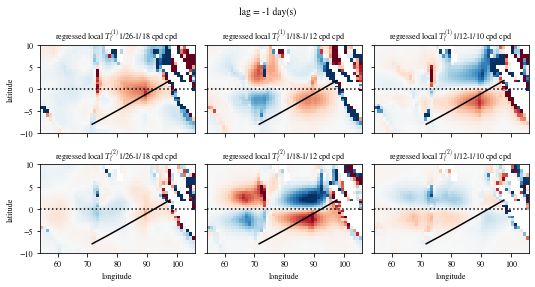

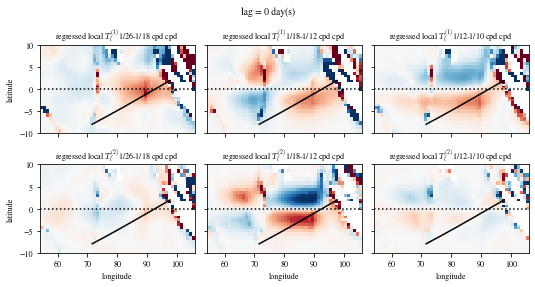

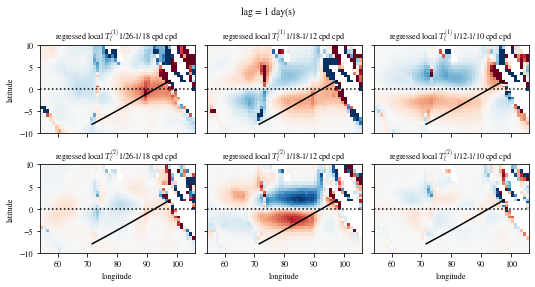

In [5]:
model,arg = 'ecco','_4modes_6bands'
nrow = 2
ds = xr.open_dataset(f'results/{model}/regression_T{arg}.nc')
lowcuts,highcuts=ds.lowcuts.values,ds.highcuts.values
for l in [14,15,16]:
    fig,ax = plt.subplots(nrow,3,figsize=(190/25.4,4),sharex=True,sharey=True)
    fig.suptitle(f'lag = {ds.lag.values[l]} day(s)')
    for n in range(nrow):
        ax[n,0].set_ylabel(r'latitude')
        for m in range(3):
            bands = f'1/{1/lowcuts[m]:.0f}-1/{1/highcuts[m]:.0f} cpd'
            ax[n,m].set_title(r'regressed local $T_l^{('+f'{n+1}'+r')}$'+f'{bands} cpd')
            im = ax[n,m].pcolormesh(ds.lon,ds.lat,ds.c.isel(i=n,fband=m,lag=l).T,
                                    vmin=-20,vmax=20,rasterized=True,cmap='RdBu_r',shading='auto')
            ax[n,m].plot(lon_k,lat_k,c='k')
            ax[n,m].set_ylim([-10,10])
            ax[n,m].axhline(0,c='k',ls=':')
            ax[-1,m].set_xlabel(r'longitude')
    plt.tight_layout()
    plt.show()

In [4]:
model,arg = 'ecco','_4modes_6bands'
nrow = 2
ds = xr.open_dataset(f'results/{model}/regression_T{arg}.nc')
lowcuts,highcuts=ds.lowcuts.values,ds.highcuts.values
filenames = []
for l in range(len(ds.lag)):
    fig,ax = plt.subplots(nrow,3,figsize=(190/25.4,4),sharex=True,sharey=True)
    fig.suptitle(f'lag = {ds.lag.values[l]} day(s)')
    for n in range(nrow):
        ax[n,0].set_ylabel(r'latitude')
        for m in range(3):
            bands = f'1/{1/lowcuts[m]:.0f}-1/{1/highcuts[m]:.0f} cpd'
            ax[n,m].set_title(r'regressed local $T_l^{('+f'{n+1}'+r')}$'+f'{bands} cpd')
            im = ax[n,m].pcolormesh(ds.lon,ds.lat,ds.c.isel(i=n,fband=m,lag=l).T,
                                    vmin=-20,vmax=20,rasterized=True,cmap='RdBu_r',shading='auto')
            ax[n,m].plot(lon_k,lat_k,c='k')
            ax[n,m].set_ylim([-10,10])
            ax[n,m].axhline(0,c='k',ls=':')
            ax[-1,m].set_xlabel(r'longitude')
    plt.tight_layout()
    
    # create file name and append it to a list
    filename = f'results/{model}/{l}.png'
    filenames.append(filename)

    # save frame
    fig.savefig(filename,dpi=300, bbox_inches='tight')
    plt.close()

# build gif
kargs = { 'duration': 0.5}
with imageio.get_writer(f'results/{model}/regressionmap_{model}_bands1.gif', mode='I',**kargs) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
for filename in set(filenames):
    os.remove(filename)

In [8]:
model,arg = 'ecco','_4modes_6bands'
nrow = 2
ds = xr.open_dataset(f'results/{model}/regression_T{arg}.nc')
lowcuts,highcuts=ds.lowcuts.values,ds.highcuts.values
filenames = []
for l in range(len(ds.lag)):
    fig,ax = plt.subplots(nrow,3,figsize=(190/25.4,4),sharex=True,sharey=True)
    fig.suptitle(f'lag = {ds.lag.values[l]} day(s)')
    for n in range(nrow):
        ax[n,0].set_ylabel(r'latitude')
        for m in range(3):
            bands = f'1/{1/lowcuts[m+3]:.0f}-1/{1/highcuts[m+3]:.0f} cpd'
            ax[n,m].set_title(r'regressed local $T_l^{('+f'{n+1}'+r')}$'+f'{bands} cpd')
            im = ax[n,m].pcolormesh(ds.lon,ds.lat,ds.c.isel(i=n,fband=m+3,lag=l).T,
                                    vmin=-13,vmax=13,rasterized=True,cmap='RdBu_r',shading='auto')
            ax[n,m].plot(lon_k,lat_k,c='k')
            ax[n,m].set_ylim([-10,10])
            ax[n,m].axhline(0,c='k',ls=':')
            ax[-1,m].set_xlabel(r'longitude')
    plt.tight_layout()
    
    # create file name and append it to a list
    filename = f'results/{model}/{l}.png'
    filenames.append(filename)

    # save frame
    fig.savefig(filename,dpi=300, bbox_inches='tight')
    plt.close()

# build gif
kargs = { 'duration': 0.5}
with imageio.get_writer(f'results/{model}/regressionmap_{model}_bands2.gif', mode='I',**kargs) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
for filename in set(filenames):
    os.remove(filename)

ecco
ofes


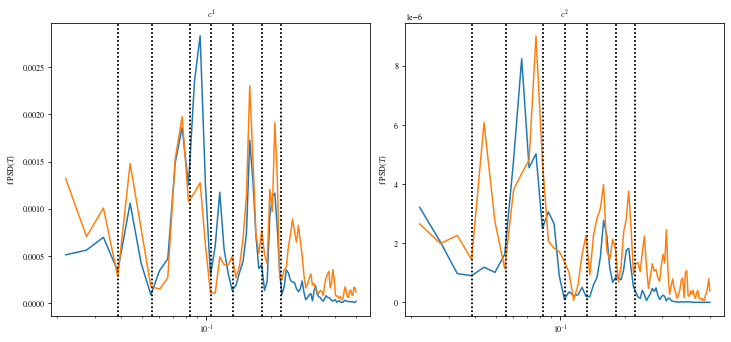

In [23]:
## Import external packages and modules
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr

def make_FFT1D(field,t,dt):
    signal=field
    FFT=np.fft.rfft(signal,signal.shape[0])

    freq1=np.fft.rfftfreq(len(t),dt)

    ###ATTENTION, FFTFREQ RETOURNE UNE FREQUENCE DONC 1/DX
    om=freq1
    PSD=np.real(2*FFT*np.conj(FFT)/len(t))

    return PSD,FFT,om

dsK = xr.open_dataset('data/knl/KTs_Nias_H08_coarsen.nc')
dx,dz = np.diff(dsK.x).mean(),np.diff(dsK.z).mean()
nmode = 4
fig,ax = plt.subplots(1,2,figsize=(10.2,4.8))
for i,model in enumerate(['ecco','ofes']):
    print(model)
    dsn2 = xr.open_dataset(f'data/{model}/n2_Nias_H08_2005.nc')
    dsm = xr.open_dataset(f'results/{model}/modes_full_{model}.nc')
    idx = np.where((dsm.x>=0)&(dsm.x<=29e5))[0]
    dx,dz = np.diff(dsK.x).mean(),np.diff(dsK.z).mean()
    #A = (dsK.SEMkernels_T*dsm.hn*dsn2.n2).sum(dim="z",skipna=True).mean(dim="x",skipna=True).values*dz
    Ax = (dsK.SEMkernels_T*dsm.hn*dsn2.n2).sum(dim="z",skipna=True)*dx*dz
    Ax = Ax.isel(x=idx,n=slice(nmode)).values.reshape((3,-1)) # n 1-5 then next xi
    u,s,vhx = np.linalg.svd(Ax)
    vh = vhx[:2].reshape((2,-1,nmode)).mean(axis=1)
    vh = vh/np.sqrt((vh**2).sum(axis=-1))[:,None]
    t = xr.open_dataset(f'results/{model}/kTdT_Nias_H08_2005.nc').t
    nsub = int(len(t)/2)
    idx3 = [[0,nsub],[nsub,2*nsub],[int(nsub/2),int(nsub/2)+nsub]]
    tecco = xr.open_dataset(f'results/{model}/kTdT_Nias_H08_2005.nc')['SEMdtaus'].values
    cecco1 = (u.T@tecco).T

    for j in range(2):    
        sigm = cecco1[:,j]
        psd3 = []
        for k in range(3):
            i1,i2 = idx3[k]
            s = sigm[i1:i2]-np.nanmean(sigm[i1:i2])
            tmphan=np.hanning(len(s))
            PSD,FFT,om = make_FFT1D(tmphan*s,t.values[i1:i2],1)
            psd3.append(PSD)
        oidx = np.where(om>2e-2)
        psd3 = np.array(psd3)
        ax[j].semilogx(om[oidx],om[oidx]*psd3.mean(axis=0)[oidx])
        ax[j].axvline(1/4.5,c='k',ls=':')
        ax[j].axvline(1/5.5,c='k',ls=':')
        ax[j].axvline(1/7.5,c='k',ls=':')
        ax[j].axvline(1/9.5,c='k',ls=':')
        ax[j].axvline(1/12,c='k',ls=':')
        ax[j].axvline(1/18,c='k',ls=':')
        ax[j].axvline(1/26,c='k',ls=':')
        ax[j].set_title(f'$c^{({j+1})}$')
        ax[j].set_ylabel(r'f PSD($T$)')

plt.tight_layout()
    #plt.savefig(f'results/{model}/spectra_Nias_H08.pdf')
plt.show()

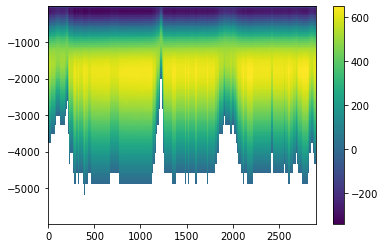

0.9948995900961405
0.0025133984713858375
0.0025133984713858397
0.9994652883655111


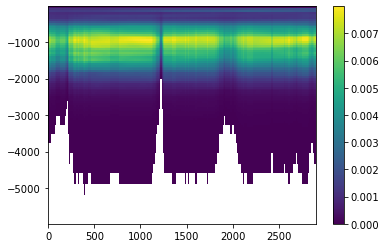

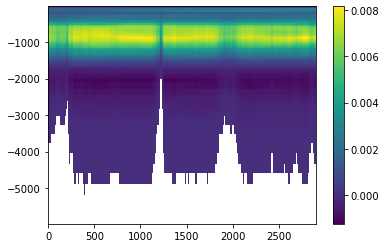

0.16026579480334993
0.10574673746012149
0.11039134671954008
0.028839767374075665


In [13]:
model = 'ecco'
lat = 2
ds0 = xr.open_dataset(f'results/{model}/n2_Nias_H08_2005_{lat}S.nc')
da = xr.open_dataset(f'results/{model}/modes_full_{model}_{lat}S.nc')
plt.figure()
plt.pcolormesh(da.x*1e-3,da.z,(da.hn[1]).T)
plt.colorbar()
plt.show()

for i in range(2):
    print(np.nanmean(np.nansum(ds0.n2*da.hn[0]*da.hn[i],axis=1)/da.H)*50)
    print(np.nanmean(np.nansum(ds0.n2*da.hn[1]*da.hn[i],axis=1)/da.H)*50)

dsh = xr.open_dataset('results/'+model+f'/hndsig1_Nias_H08_2005_{lat}S.nc')
xidx = np.where(~np.isnan(dsh.hndsig1.isel(n=0,t=0)))[0]
xidx = np.intersect1d(xidx,np.nonzero(dsh.hndsig1.isel(n=0,t=0).values)[0])
wx = np.hanning(len(xidx))
ds = xr.open_dataset('data/knl/KTs_Nias_H08_coarsen.nc')
dx,dz = np.diff(ds.x).mean(),np.diff(ds.z).mean()
zk = ds.z.values
kT = np.nansum(ds.SEMkernels_T,axis=1)*dx
u, s, vh = np.linalg.svd(kT, full_matrices=True)
v2 = (5e3/dz)**0.5*vh[:2,:]
plt.figure()
plt.pcolormesh(da.x*1e-3,da.z,(ds0.n2*da.hn[0]*v2[0].reshape((1,-1))).T)
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(da.x*1e-3,da.z,(ds0.n2*da.hn[0]*v2[1].reshape((1,-1))).T)
plt.colorbar()
plt.show()
plt.figure()
plt.plot(da.x*1e-3,np.nansum(ds0.n2*da.hn[0]*v2[1].reshape((1,-1)),axis=1))
plt.plot(da.x*1e-3,np.nansum(ds0.n2*da.hn[1]*v2[1].reshape((1,-1)),axis=1))
for i in range(2):
    print(np.nansum(wx*np.nansum(ds0.n2*da.hn[0]*v2[i].reshape((1,-1)),axis=1)[xidx])/np.sum(wx))
    print(np.nansum(wx*np.nansum(ds0.n2*da.hn[1]*v2[i].reshape((1,-1)),axis=1)[xidx])/np.sum(wx))

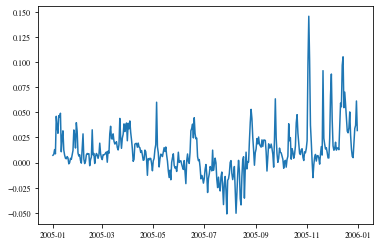

D:\ProgramData\Miniconda3\envs\obspy\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


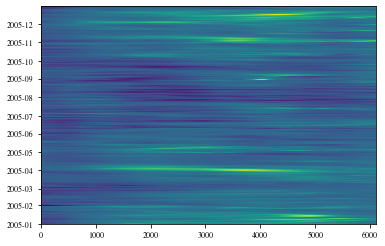

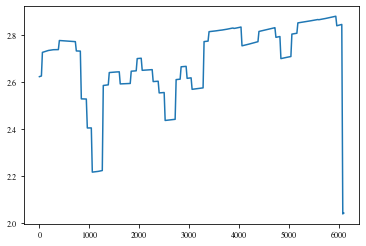

In [2]:
model = 'ecco'
lat = 3
ds = xr.open_dataset('results/'+model+f'/hndsig1_Nias_H08_2005_{lat}S.nc')
tau = True
if tau:
    dstau = xr.open_dataset(f'results/ecco/tauxy_Nias_H08_2005_{lat}S.nc')
    var = dstau.taux.values
else:
    var = ds.hndsig1.isel(n=0).values 
xidx = np.where(~np.isnan(ds.hndsig1.isel(n=0,t=0)))[0]
xidx = np.intersect1d(xidx,np.nonzero(ds.hndsig1.isel(n=0,t=0).values)[0])
#print(xmax)
plt.figure()
plt.plot(ds.t,var[:,-1])
plt.show()
plt.figure()
plt.pcolormesh(1e-3*ds.x.values[xidx],ds.t.values,var[:,xidx])
plt.show()

dsm = xr.open_dataset('results/'+model+'/modes_full_'+model+f'_{lat}S.nc')
plt.figure()
plt.plot(1e-3*dsm.x.values[xidx],dsm.cn.isel(n=0,x=xidx))
plt.show()

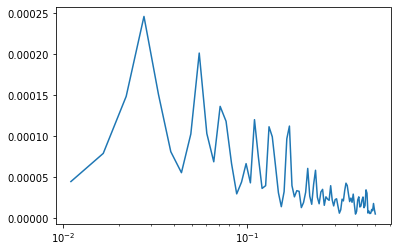

In [3]:
def make_FFT1D(field,t,dt):
    signal=field
    FFT=np.fft.rfft(signal,signal.shape[0])

    freq1=np.fft.rfftfreq(len(t),dt)

    ###ATTENTION, FFTFREQ RETOURNE UNE FREQUENCE DONC 1/DX
    om=freq1
    #FFT=FFT/np.sqrt(signal.shape[0])
    PSD=np.real(2*FFT*np.conj(FFT)/len(t))

    return PSD,FFT,om

nsub = int(len(ds.t)/2)
idx3 = [[0,nsub],[nsub,2*nsub],[int(nsub/2),int(nsub/2)+nsub]]
sigm = var[:,int(len(ds.x)/2)]
psd3 = []
for i in range(3):
    i1,i2 = idx3[i]
    s = sigm[i1:i2]-np.nanmean(sigm[i1:i2])
    tmphan=np.hanning(len(s))
    PSD,FFT,om = make_FFT1D(tmphan*s,ds.t.values[i1:i2],1)
    psd3.append(PSD)
oidx = np.where(om>1e-2)
psd3 = np.array(psd3)
plt.semilogx(om[oidx],om[oidx]*psd3.mean(axis=0)[oidx])
plt.show()

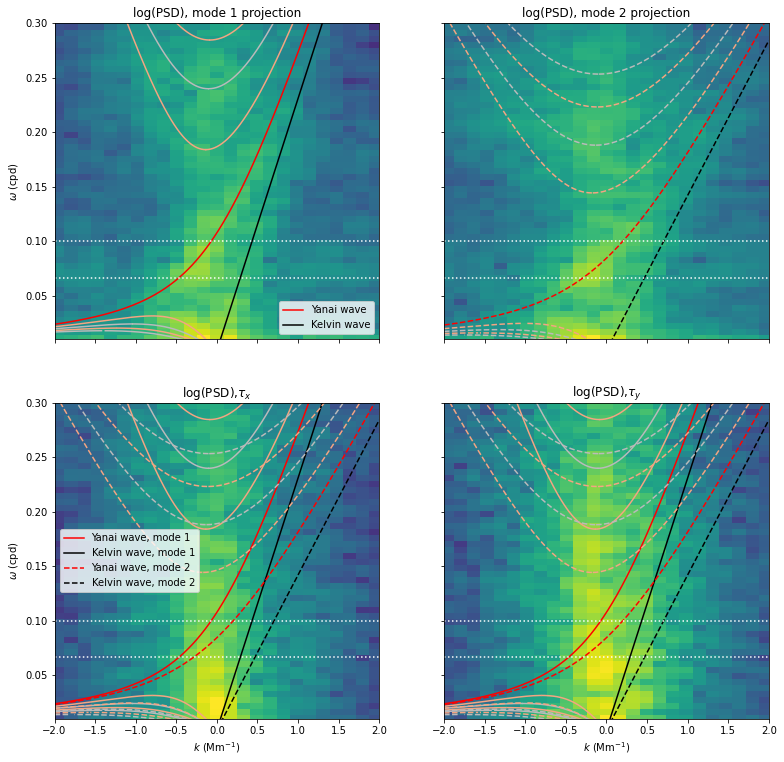

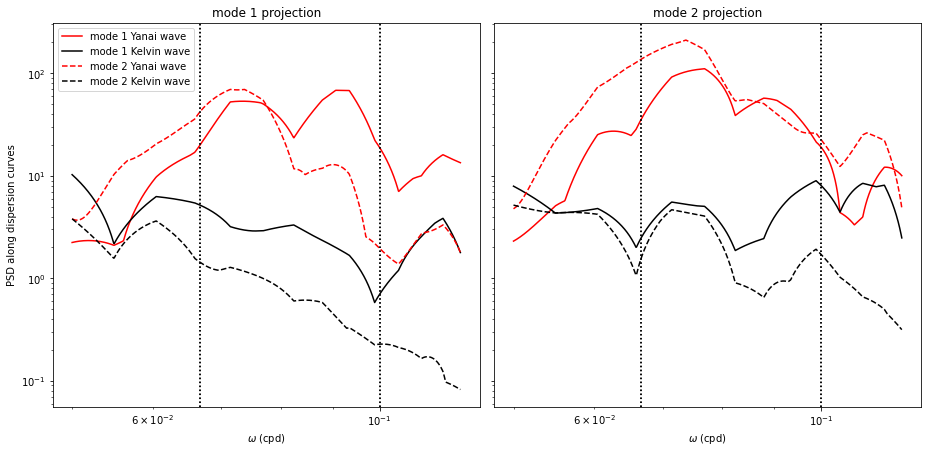

In [4]:
def make_FFT2D(field,t,dt,x,dx):
    signal=field[:,::-1]
    FFT=np.fft.fftshift(np.fft.rfft2(signal,signal.shape),axes=0)
    freq=np.fft.rfftfreq(len(t),dt)
    k = np.fft.fftshift(np.fft.fftfreq(len(x),dx))

    ###ATTENTION, FFTFREQ RETOURNE UNE FREQUENCE DONC 1/DX
    FFT=FFT/np.sqrt(signal.shape[0]*signal.shape[1])
    PSD=np.real(FFT*np.conj(FFT))

    return PSD,freq,k

plot = 'full'
dt,dx = 1,(ds.x[1]-ds.x[0]).values/1e6
wt,wx = np.hanning(nsub),np.hanning(len(xidx))
w2d = wx.reshape((-1,1))*wt.reshape((1,-1))

beta = 2.3e-11*1e6*86400

if model == 'ecco':
    sigs = [dstau.taux,dstau.tauy]
lbls = [r'$\tau_x$',r'$\tau_y$']
lss = ['-','--']
fig,axs = plt.subplots(2,2,figsize=(190/25.4, 190/25.4),sharex=True,sharey=True)
psdhn = []
for n in range(2):
    psd3 = []
    for i in range(3):
        i1,i2 = idx3[i]
        signal=ds.hndsig1.isel(n=n,t=slice(i1,i2),x=xidx).values.T
        PSD,freq,k = make_FFT2D(w2d*signal,
                                ds.t.values[i1:i2],dt,
                                ds.x.values[xidx],dx)
        psd3.append(PSD)
    psd3 = np.array(psd3)
    
    if plot=='full':
        fidx = np.where(freq>1e-2)[0]
    else:
        fidx = np.where((freq>0.06)&(freq<0.12))[0]
    kidx = np.where(np.abs(k)<2.5)[0]
    freq,k = freq[fidx],k[kidx] 
    psdhn.append((psd3.mean(axis=0)[kidx][:,fidx]).flatten())
    
    if plot=='full':
        if n==0:
            fig2,axs2 = plt.subplots(1,2,figsize=(12.8,6.4),sharey=True)
        for n1 in range(2):
            c = np.sum(dsm.cn.isel(n=n1,x=xidx).values*wx)/np.sum(wx)/1e6*86400

            # dispersion curves
            yanai = lambda omega : -beta/omega+omega/c
            kelvin = lambda omega : omega/c
            omgs = np.linspace(.05,.12,int(1e3))
            kys = yanai(2*np.pi*omgs)/(2*np.pi)
            kks = kelvin(2*np.pi*omgs)/(2*np.pi)

            knots = (k,freq)
            itpsd = RGI(knots,psd3.mean(axis=0)[kidx][:,fidx])
            axs2[n].set_title(f'mode {n+1} projection')
            locsk = np.empty([int(1e3),2])
            locsk[:,0],locsk[:,1] = kys,omgs
            axs2[n].loglog(omgs,itpsd(locsk),c='r',ls=lss[n1],label=f'mode {n1+1} Yanai wave')
            locsk[:,0],locsk[:,1] = kks,omgs
            axs2[n].loglog(omgs,itpsd(locsk),c='k',ls=lss[n1],label=f'mode {n1+1} Kelvin wave')
            axs2[n].axvline(0.1,c='k',ls=':')
            axs2[n].axvline(1/15,c='k',ls=':')
            axs2[n].set_xlabel(r'$\omega$ (cpd)')
            
    c = np.sum(dsm.cn.isel(n=n,x=xidx).values*wx)/np.sum(wx)/1e6*86400

    # dispersion curves
    yanai = lambda omega : -beta/omega+omega/c
    kelvin = lambda omega : omega/c
    rgp = lambda omega,m : np.where((beta/omega-2*omega/c)**2 < 8*m*beta/c,np.nan,-beta/(2*omega) + 1/2*np.sqrt((beta/omega-2*omega/c)**2 - 8*m*beta/c))
    rgm = lambda omega,m : np.where((beta/omega-2*omega/c)**2 < 8*m*beta/c,np.nan,-beta/(2*omega) - 1/2*np.sqrt((beta/omega-2*omega/c)**2 - 8*m*beta/c))              
    
    fw = np.linspace(0,0.3,int(1e5))
    ky = yanai(2*np.pi*fw)/(2*np.pi)
    kk = kelvin(2*np.pi*fw)/(2*np.pi)
    kr = rgp(2*np.pi*fw,np.arange(1,5).reshape(-1,1))/(2*np.pi)
    kg = rgm(2*np.pi*fw,np.arange(1,5).reshape(-1,1))/(2*np.pi)
    
    axs[0,n].pcolormesh(k,freq,np.log(psd3.mean(axis=0))[kidx][:,fidx].T,shading='nearest')
    axs[0,n].plot(ky,fw,c='r',ls=lss[n],label='Yanai wave')
    axs[0,n].plot(kk,fw,c='k',ls=lss[n],label='Kelvin wave')
    axs[0,n].plot(kr[::2].T,fw,kg[::2].T,fw,c='#f4a582',ls=lss[n])
    axs[0,n].plot(kr[1::2].T,fw,kg[1::2].T,fw,c='#bababa',ls=lss[n])
    
    if model == 'ecco':
        psd3tau = []
        for i in range(3):
            i1,i2 = idx3[i]
            signal=sigs[n].isel(t=slice(i1,i2),x=xidx).values.T
            PSD,ftau,ktau = make_FFT2D(w2d*signal,
                                    ds.t.values[i1:i2],dt,
                                    ds.x.values[xidx],dx)
            psd3tau.append(PSD)
        psd3tau = np.array(psd3tau)

        axs[1,n].pcolormesh(k,freq,np.log(psd3tau.mean(axis=0))[kidx][:,fidx].T,shading='nearest')
        axs[1,0].plot(ky,fw,c='r',ls=lss[n],label=f'Yanai wave, mode {n+1}')
        axs[1,0].plot(kk,fw,c='k',ls=lss[n],label=f'Kelvin wave, mode {n+1}')
        axs[1,1].plot(ky,fw,c='r',ls=lss[n])
        axs[1,1].plot(kk,fw,c='k',ls=lss[n])
        for j in range(2):
            axs[1,j].plot(kr[::2].T,fw,kg[::2].T,fw,c='#f4a582',ls=lss[n])
            axs[1,j].plot(kr[1::2].T,fw,kg[1::2].T,fw,c='#bababa',ls=lss[n])
    
    if plot=='full':
        for j in range(2):
            axs[j,n].set_ylim([0.01,0.3])
    else:
        for j in range(2):
            axs[j,n].set_ylim([0.06,0.11])
        
    axs[1,n].set_xlim([-2,2])
    axs[1,n].set_xlabel(r'$k\ (\mathrm{Mm}^{-1})$')
    axs[0,n].set_title(f'log(PSD), mode {n+1} projection')
    axs[1,n].set_title('log(PSD),'+lbls[n])
    for j in range(2):
        axs[j,n].axhline(0.1,c='w',ls=':')
        axs[j,n].axhline(1/15,c='w',ls=':')
for j in range(2):
    axs[j,0].legend()
    axs[j,0].set_ylabel(r'$\omega$ (cpd)')
plt.tight_layout()
if plot=='full':
    axs2[0].legend()
    axs2[0].set_ylabel(r'PSD along dispersion curves')
#fig2.savefig(f'results/{model}/PSDonCurves_hn_{lat}S.pdf')
#plt.savefig('results/'+model+'/fk_hn_tau_'+plot+f'_{lat}S.pdf')
plt.show()

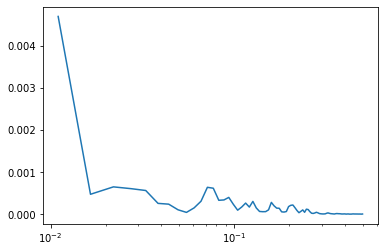

In [4]:
dsv = xr.open_dataset(f'results/ecco/v2dsig1_Nias_H08_2005.nc')
#xr.open_dataset(f'results/ecco/hndsig1_Nias_H08_2005_3S.nc')
stest = dsv.v2dsig1.isel(n=1)-dsv.v2dsig1.isel(n=1).values.mean()
#np.sum(wx.reshape((1,-1))*dsv.hndsig1.isel(n=0,x=xidx).values,axis=-1)/np.sum(wx)
psd3 = []
for i in range(3):
    i1,i2 = idx3[i]
    s = stest[i1:i2]
    tmphan=np.hanning(len(s))
    PSD,FFT,om = make_FFT1D(np.sqrt(8/3)*tmphan*s,ds.t.values[i1:i2],1)
    psd3.append(PSD)
oidx = np.where(om>1e-2)
psd3 = np.array(psd3)
plt.semilogx(om[oidx],om[oidx]*psd3.mean(axis=0)[oidx])
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     6645.
Date:                Mon, 12 Sep 2022   Prob (F-statistic):          4.47e-286
Time:                        13:46:21   Log-Likelihood:                 916.02
No. Observations:                 365   AIC:                            -1826.
Df Residuals:                     362   BIC:                            -1814.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.376e-05      0.001     -0.052      0.9

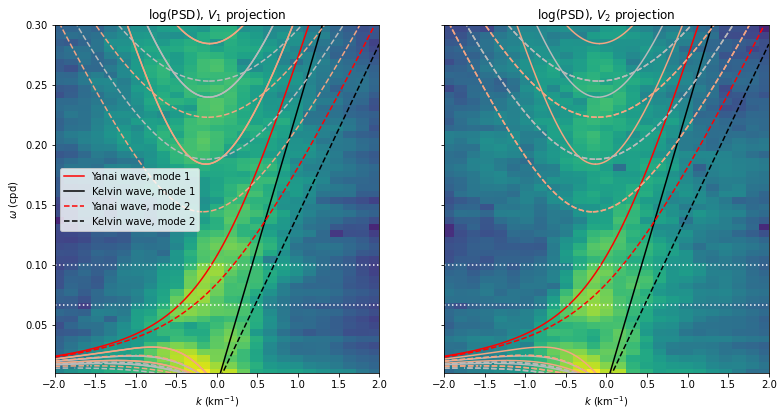

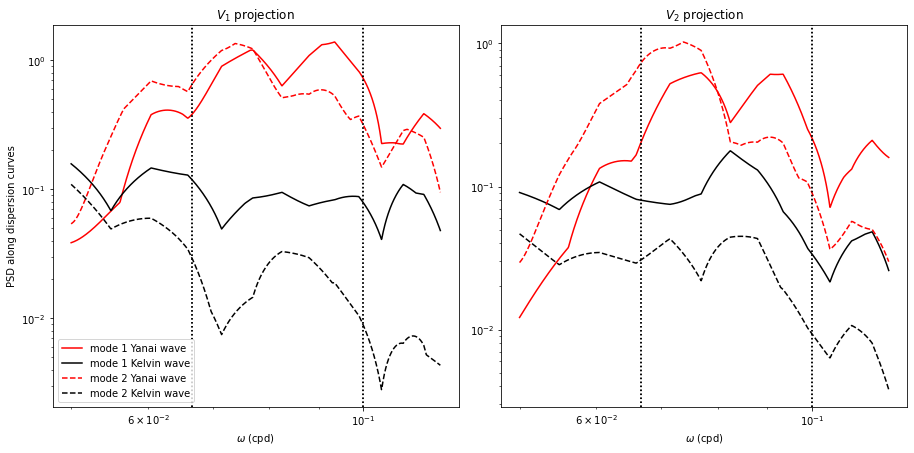

In [5]:
import statsmodels.api as sm
import pandas as pd
d = {'h1':np.sum(wx.reshape((1,-1))*ds.hndsig1.isel(n=0,x=xidx).values,axis=-1)/np.sum(wx),
     'h2':np.sum(wx.reshape((1,-1))*ds.hndsig1.isel(n=1,x=xidx).values,axis=-1)/np.sum(wx)}
x = pd.DataFrame(d)
x = sm.add_constant(x) # adding a constant
    
dsv = xr.open_dataset(f'results/{model}/vndsig1_Nias_H08_2005_{lat}S.nc')
plot = 'full'
fig,axs = plt.subplots(1,2,figsize=(12.8,6.4),sharey=True)
for n in range(2):
    y = np.sum(wx.reshape((1,-1))*dsv.vndsig1.isel(n=n,x=xidx).values,axis=-1)/np.sum(wx)
    # with statsmodels
    model = sm.OLS(y, x).fit()
    predictions = model.predict(x) 

    print_model = model.summary()
    print(print_model)
    
    psd3 = []
    for i in range(3):
        i1,i2 = idx3[i]
        signal=dsv.vndsig1.isel(n=n,t=slice(i1,i2),x=xidx).values.T
        PSD,freq,k = make_FFT2D(w2d*signal,
                                ds.t.values[i1:i2],dt,
                                ds.x.values[xidx],dx)
        psd3.append(PSD)
    psd3 = np.array(psd3)
    
    if plot=='full':
        fidx = np.where(freq>1e-2)[0]
    else:
        fidx = np.where((freq>0.06)&(freq<0.12))[0]
    kidx = np.where(np.abs(k)<2.5)[0]
    freq,k = freq[fidx],k[kidx]               
    
    if plot=='full':
        if n==0:
            fig2,axs2 = plt.subplots(1,2,figsize=(12.8,6.4))#,sharey=True)
        for n1 in range(2):
            c = np.sum(dsm.cn.isel(n=n1,x=xidx).values*wx)/np.sum(wx)/1e6*86400

            # dispersion curves
            yanai = lambda omega : -beta/omega+omega/c
            kelvin = lambda omega : omega/c
            omgs = np.linspace(.05,.12,int(1e3))
            kys = yanai(2*np.pi*omgs)/(2*np.pi)
            kks = kelvin(2*np.pi*omgs)/(2*np.pi)

            knots = (k,freq)
            itpsd = RGI(knots,psd3.mean(axis=0)[kidx][:,fidx])
            axs2[n].set_title(f'$V_{n+1}$ projection')
            locsk = np.empty([int(1e3),2])
            locsk[:,0],locsk[:,1] = kys,omgs
            axs2[n].loglog(omgs,itpsd(locsk),c='r',ls=lss[n1],label=f'mode {n1+1} Yanai wave')
            locsk[:,0],locsk[:,1] = kks,omgs
            axs2[n].loglog(omgs,itpsd(locsk),c='k',ls=lss[n1],label=f'mode {n1+1} Kelvin wave')
            axs2[n].axvline(0.1,c='k',ls=':')
            axs2[n].axvline(1/15,c='k',ls=':')
            axs2[n].set_xlabel(r'$\omega$ (cpd)')
    
    c = np.sum(dsm.cn.isel(n=n,x=xidx).values*wx)/np.sum(wx)/1e6*86400

    # dispersion curves
    yanai = lambda omega : -beta/omega+omega/c
    kelvin = lambda omega : omega/c
    rgp = lambda omega,m : np.where((beta/omega-2*omega/c)**2 < 8*m*beta/c,np.nan,-beta/(2*omega) + 1/2*np.sqrt((beta/omega-2*omega/c)**2 - 8*m*beta/c))
    rgm = lambda omega,m : np.where((beta/omega-2*omega/c)**2 < 8*m*beta/c,np.nan,-beta/(2*omega) - 1/2*np.sqrt((beta/omega-2*omega/c)**2 - 8*m*beta/c))
    
    fw = np.linspace(0,0.3,int(1e5))
    ky = yanai(2*np.pi*fw)/(2*np.pi)
    kk = kelvin(2*np.pi*fw)/(2*np.pi)
    kr = rgp(2*np.pi*fw,np.arange(1,5).reshape(-1,1))/(2*np.pi)
    kg = rgm(2*np.pi*fw,np.arange(1,5).reshape(-1,1))/(2*np.pi)
    
    axs[n].pcolormesh(k,freq,np.log(psd3.mean(axis=0))[kidx][:,fidx].T,shading='nearest')
    for j in range(2):
        axs[j].plot(ky,fw,c='r',ls=lss[n],label=f'Yanai wave, mode {n+1}')
        axs[j].plot(kk,fw,c='k',ls=lss[n],label=f'Kelvin wave, mode {n+1}')
        axs[j].plot(kr[::2].T,fw,kg[::2].T,fw,c='#f4a582',ls=lss[n])
        axs[j].plot(kr[1::2].T,fw,kg[1::2].T,fw,c='#bababa',ls=lss[n])
    axs[n].plot(kr[::2].T,fw,kg[::2].T,fw,c='#f4a582',ls=lss[n])
    axs[n].plot(kr[1::2].T,fw,kg[1::2].T,fw,c='#bababa',ls=lss[n])
    axs[n].set_ylim([0.06,0.11])
    axs[n].set_xlim([-2,2])
    axs[n].set_xlabel(r'$k\ (\mathrm{km}^{-1})$')
    axs[n].set_title(f'log(PSD), $V_{n+1}$ projection')
    axs[n].axhline(0.1,c='w',ls=':')
    axs[n].axhline(1/15,c='w',ls=':')

    if plot=='full':
            axs[n].set_ylim([0.01,0.3])
    else:
            axs[n].set_ylim([0.06,0.11])
axs[0].legend()
axs[0].set_ylabel(r'$\omega$ (cpd)')
if plot=='full':
    axs2[0].legend()
    axs2[0].set_ylabel(r'PSD along dispersion curves')
plt.tight_layout()
#fig2.savefig(f'results/{model}/PSDonCurves_vn_{lat}S.pdf')
#fig.savefig(f'results/{model}/fk_vn_{plot}_{lat}S.pdf')
plt.show()

In [1]:
## Import external packages and modules
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from scipy import arange, exp
import xarray as xr
import gsw as gsw
import great_circle_calculator.great_circle_calculator as gcc
from scipy.interpolate import RegularGridInterpolator as RGI
from scipy.interpolate import RectBivariateSpline as RBS
from datetime import datetime,timedelta,date,timezone
import itertools
import warnings
warnings.filterwarnings('ignore')
import time

src,stn = 'Nias','H08'
name = src+'_'+stn
resolution = 'coarsen'

# Define path end points
if stn == 'H01':
    p10,p20 = (114.14, -34.88),(96.95, 1.12)
elif stn == 'H08':
    p10,p20 = (72.49, -7.65),(96.92, 1.62)
    #p10,p20 = (72.49, 0),(96.92, 0)
elif stn == 'DGAR':
    p10,p20 = (72.45, -7.41),(96.96, 1.63)
d0 = gcc.distance_between_points(p10, p20, unit='meters')
crs1,crs2 = gcc.bearing_at_p1(p10, p20),gcc.bearing_at_p1(p20, p10)

# output timestep, and output choices 
# for vertical anomalies, weighted anomalies
dtself,vert,wdtau,xvert = 1,0,1,0
mdT =0
if mdT:
    ds = xr.open_dataset(f'results/ofes/modes_full_ofes.nc')
    ns = ds.n
    idx_topo = np.where(np.isnan(ds.hn[0].values))

    xk,zk = ds.x,ds.z
    xmaxk,xmink = max(xk),min(xk)
    nxk,nzk = len(xk),len(zk)
    dxk,dzk = np.ptp(xk.values)/(nxk-1),np.ptp(zk.values)/(nzk-1)
else:
    ds = xr.open_dataset(f'data/knl/nias_kernels/coarsen/KTs_'+name+'_'+resolution+'.nc')
    fs = ds.f
    idx_topo = np.where(ds.SEMkernels_T[0].values==0)

    xk,zk = ds.x.values,ds.z.values
    xmaxk,xmink = max(xk),min(xk)
    nxk,nzk = len(xk),len(zk)
    dxk,dzk = np.ptp(xk)/(nxk-1),np.ptp(zk)/(nzk-1)

ds_ref = xr.open_dataset(f'data/ofes/sigma1_2005_mean.nc')
lon_e = ds_ref.lon
lat_e = ds_ref.lat
dlon_e = np.diff(lon_e).max()
dlat_e = np.diff(lat_e).max()
ze = ds_ref.z
nze = len(ze)

# kernel end points
p2 = gcc.point_given_start_and_bearing(p10, crs1, xmaxk, unit='meters')
p1 = gcc.point_given_start_and_bearing(p20, crs2, d0-xmink, unit='meters')
lonT1,lonT2 = p1[0],p2[0]
latT1,latT2 = p1[1],p2[1]

ref,crho = 0,0
# output timestep, and output choices 
# for 1d vertical anomalies, scalar weighted anomalies and temperature kernels
timestep = 'daily'
    
########
# fill in coastal and bottom points (ignores points at the edge of the array)
def filledges(a):
    # fill in all points that have a missing value with the average of the eight surrounding points (if there are any values there)
    nx, ny, nz = a.shape
    b = np.empty([nx, ny, nz])
    b[:,:,:] = a[:,:,:]
    for i,j,k in itertools.product(range(1,nx-1), range(1,ny-1), range(nz)):
        if (np.isnan(a[i,j,k]) and any(~np.isnan(a[i-1:i+2,j-1:j+2,k]).flatten())):
            b[i,j,k] = np.nanmean(a[i-1:i+2,j-1:j+2,k])
    # fill in bottom points
    for i,j,k in itertools.product(range(nx), range(ny), range(nz-1)):
        if (np.isnan(a[i,j,k]) and ~np.isnan(a[i,j,k+1])):
            b[i,j,k] = a[i,j,k+1]
    return b

# fill in bottom points along the path
def fillbtm(a,n):
    # fill in all points that have a missing value with the average of the eight surrounding points (if there are any values there)
    nx, nz = a.shape
    b = np.empty([nx, nz])
    b[:,:] = a[:,:]
    for i,k in itertools.product(range(nx), range(nz-1)):
        if (np.isnan(a[i,k]) and ~np.isnan(a[i,k+1])):
            b[i,k] = a[i,k+1]
            if n>0:
                b[i,max([0,k-n]):k] = a[i,k+1]
    return b

def ip(frac):
    return gcc.intermediate_point(p1, p2, frac)

# sound speed as a function of in situ temperature and depth
def c(pT, S, lon, lat, z):
    p = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, p, lon, lat)
    CT = gsw.CT_from_pt(SA, pT)
    c = gsw.sound_speed(SA, CT, p)
    return c

# in situ temperature from potential temperature
def T(pT, S, lon, lat, z):
    p = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, p, lon, lat)
    CT = gsw.CT_from_pt(SA, pT)
    T = gsw.t_from_CT(SA, CT, p)
    return T

# in situ density as a function of salinity and temperature
def rho(pT, S, lon, lat, z):
    p = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, p, lon, lat)
    CT = gsw.CT_from_pt(SA, pT)
    rho = gsw.rho(SA, CT, p)
    return rho

# in situ density as a function of salinity and temperature
def prho0(pT, S, lon, lat, z):
    p = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, p, lon, lat)
    CT = gsw.CT_from_pt(SA, pT)
    prho0 = gsw.sigma0(SA, CT)+1e3
    return prho0

# in situ density as a function of salinity and temperature
def sigma1(pT, S, lon, lat, z):
    p = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, p, lon, lat)
    CT = gsw.CT_from_pt(SA, pT)
    prho1 = gsw.sigma1(SA, CT)+1e3
    return prho1

# absolute salinity from potential temperature
def SA(S, lon, lat, z):
    p = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, p, lon, lat)
    return SA

# temperature sensitivity of sound speed
def dcdT(pT, S, lon, lat, z):
    eps = 1e-4
    p = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, p, lon, lat)
    CT = gsw.CT_from_pt(SA, pT)
    T = gsw.t_from_CT(SA, CT, p)
    CT1 = gsw.CT_from_t(SA,T-eps,p)
    CT2 = gsw.CT_from_t(SA,T+eps,p)
    c1 = gsw.sound_speed(SA, CT1, p)
    c2 = gsw.sound_speed(SA, CT2, p)
    return (c2-c1)/(2*eps)

# salinity sensitivity of sound speed
def dcdS(pT, S, lon, lat, z):
    eps = 1e-4
    p = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, p, lon, lat)
    CT1 = gsw.CT_from_pt(SA-eps, pT)
    CT2 = gsw.CT_from_pt(SA+eps, pT)
    c1 = gsw.sound_speed(SA-eps, CT1, p)
    c2 = gsw.sound_speed(SA+eps, CT2, p)
    return (c2-c1)/(2*eps)

# 1d extrapolation
def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return np.array(list(map(pointwise, np.array(xs))))

    return ufunclike

# Get (lon,lat) for the grid points along the path
fr = np.linspace(0,1,nxk)
gridT = np.array(list(map(ip,fr)))
lat_k, lon_k = gridT[:,1],gridT[:,0]

In [2]:
def cdif(x):
    return np.insert(x[2:]-x[:-2],[0,-1],[x[1]-x[0],x[-1]-x[-2]])
def grad(x,y):
    return cdif(y)/cdif(x)
lat = 0
model = 'ecco'
da = xr.open_dataarray(f'results/'+model+f'/sig1xz_Nias_H08_2005_{lat}S.nc')
n2 = np.full(da.values.shape,np.nan)
xidx = np.where((da.x>=0)&(da.x<=6300e3))[0]
for i in xidx:
    n2[i,:] = -9.8*grad(da.z.values,da[i,:].values)/da[i,:].values

ds = xr.Dataset(
    data_vars=dict(
        n2 = (["x", "z"], n2),),
    coords=dict(
        x = da.x.values,
        z = da.z.values,),
        attrs=dict(description="mean stratification from OFES 2005 daily"),
)
#ds.to_netcdf(f'results/'+model+f'/n2_Nias_H08_2005_{lat}S.nc')

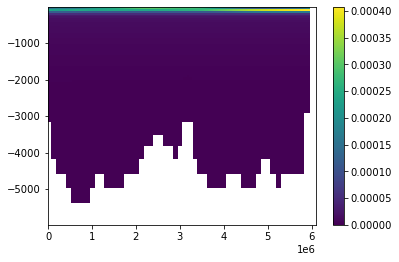

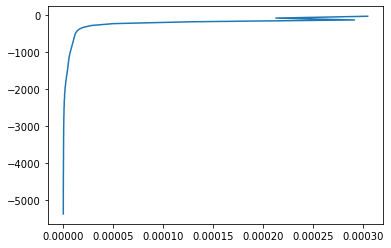

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
plt.figure()
plt.pcolormesh(da.x,da.z,n2.T)
plt.colorbar()
plt.show()
plt.figure()
plt.plot(np.nanmean(n2,axis=0),da.z)
plt.show()
#pd.DataFrame(data={'z':da.z.values,'n2':np.nanmean(n2,axis=0)}).to_csv('results/ofes/n2_Nias_H08_2005_dy.csv',index=False)

In [2]:
ds_temp = xr.open_dataset('data/ofes/temp_ofes_2005_dy.nc')
ds_salt = xr.open_dataset('data/ofes/salinity_ofes_2005_dy.nc')
dt_e = ds_temp.time.values
lon_e = ds_temp.lon.values
lat_e = ds_temp.lat.values
# reverse depth coordinate
ze = -ds_temp.lev.values[::-1]
nx,ny,nze = len(lon_e),len(lat_e),len(ze)
ds_temp

<xarray.Dataset>
Dimensions:  (time: 365, lon: 270, lat: 120, lev: 105)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2005-12-31
  * lon      (lon) float64 72.05 72.15 72.25 72.35 ... 98.65 98.75 98.85 98.95
  * lat      (lat) float64 -7.95 -7.85 -7.75 -7.65 -7.55 ... 3.65 3.75 3.85 3.95
  * lev      (lev) float64 2.5 7.5 12.5 17.5 ... 6.75e+03 7.05e+03 7.35e+03
Data variables:
    temp     (time, lev, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Oct 18 09:47:14 2022: cdo -sellonlatbox,72,99,-8,4 /S/d...
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...

In [3]:
for e,te in enumerate(dt_e):
    print(te)
    if e==0:
        pr1_2005_dy = T(ds_temp.temp[e], ds_salt.salinity[e], 
                            lon_e.reshape((1,1,-1)),lat_e.reshape((1,-1,1)), ze[::-1].reshape((-1,1,1)))
    else:
        pr1_2005_dy = pr1_2005_dy+T(ds_temp.temp[e], ds_salt.salinity[e], 
                                          lon_e.reshape((1,1,-1)),lat_e.reshape((1,-1,1)), ze[::-1].reshape((-1,1,1)))

2005-01-01T00:00:00.000000000
2005-01-02T00:00:00.000000000
2005-01-03T00:00:00.000000000
2005-01-04T00:00:00.000000000
2005-01-05T00:00:00.000000000
2005-01-06T00:00:00.000000000
2005-01-07T00:00:00.000000000
2005-01-08T00:00:00.000000000
2005-01-09T00:00:00.000000000
2005-01-10T00:00:00.000000000
2005-01-11T00:00:00.000000000
2005-01-12T00:00:00.000000000
2005-01-13T00:00:00.000000000
2005-01-14T00:00:00.000000000
2005-01-15T00:00:00.000000000
2005-01-16T00:00:00.000000000
2005-01-17T00:00:00.000000000
2005-01-18T00:00:00.000000000
2005-01-19T00:00:00.000000000
2005-01-20T00:00:00.000000000
2005-01-21T00:00:00.000000000
2005-01-22T00:00:00.000000000
2005-01-23T00:00:00.000000000
2005-01-24T00:00:00.000000000
2005-01-25T00:00:00.000000000
2005-01-26T00:00:00.000000000
2005-01-27T00:00:00.000000000
2005-01-28T00:00:00.000000000
2005-01-29T00:00:00.000000000
2005-01-30T00:00:00.000000000
2005-01-31T00:00:00.000000000
2005-02-01T00:00:00.000000000
2005-02-02T00:00:00.000000000
2005-02-03

2005-10-02T00:00:00.000000000
2005-10-03T00:00:00.000000000
2005-10-04T00:00:00.000000000
2005-10-05T00:00:00.000000000
2005-10-06T00:00:00.000000000
2005-10-07T00:00:00.000000000
2005-10-08T00:00:00.000000000
2005-10-09T00:00:00.000000000
2005-10-10T00:00:00.000000000
2005-10-11T00:00:00.000000000
2005-10-12T00:00:00.000000000
2005-10-13T00:00:00.000000000
2005-10-14T00:00:00.000000000
2005-10-15T00:00:00.000000000
2005-10-16T00:00:00.000000000
2005-10-17T00:00:00.000000000
2005-10-18T00:00:00.000000000
2005-10-19T00:00:00.000000000
2005-10-20T00:00:00.000000000
2005-10-21T00:00:00.000000000
2005-10-22T00:00:00.000000000
2005-10-23T00:00:00.000000000
2005-10-24T00:00:00.000000000
2005-10-25T00:00:00.000000000
2005-10-26T00:00:00.000000000
2005-10-27T00:00:00.000000000
2005-10-28T00:00:00.000000000
2005-10-29T00:00:00.000000000
2005-10-30T00:00:00.000000000
2005-10-31T00:00:00.000000000
2005-11-01T00:00:00.000000000
2005-11-02T00:00:00.000000000
2005-11-03T00:00:00.000000000
2005-11-04

In [4]:
ds = xr.Dataset(
    data_vars=dict(
        itemp = (["lon", "lat", "z"], pr1_2005_dy[::-1,:,:].T/(1+e)),),
    coords=dict(
        lon = lon_e,
        lat = lat_e,
        z = ze,),
        attrs=dict(description="mean in-situ temperature from OFES 2005 daily"),
)
ds.to_netcdf('data/ofes/itemp_2005_mean.nc')

In [ ]:
# fill in bottom points along the path
def fillbtm2(a):  
  # fill in all points that have a missing value with the average of the two surrounding points (if there are any values there)
    nx, nz = a.shape
    b = np.empty([nx, nz])
    b[:,:] = a[:,:]
    for i in range(nx):
        for k in range(nz-1):
            if (np.isnan(b[i,nz-k-2]) and ~np.isnan(b[i,nz-k-1])):
                b[i,nz-k-2] = b[i,nz-k-1]
    return b
i_k = np.where((lon_e<=max(p10[0],p20[0])+dlon_e) & (lon_e>=min(p10[0],p20[0])-dlon_e))[0]
j_k = np.where((lat_e<=max(p10[1],p20[1])+dlat_e) & (lat_e>=min(p10[1],p20[1])-dlat_e))[0]
T_ref = ds.sigma1.isel(lon=i_k,lat=j_k).values

idx_lonk = np.where((lon_k>=lon_e[i_k].min()) & (lon_k<=lon_e[i_k].max()))[0]
idx_latk = np.where((lat_k>=lat_e[j_k].min()) & (lat_k<=lat_e[j_k].max()))[0]
idx_k = np.intersect1d(idx_lonk,idx_latk)

# interpolate horizontally onto great circle path
knots = (lon_e[i_k], lat_e[j_k])
locsk = np.empty([len(idx_k),2])
locsk[:,0],locsk[:,1] = lon_k[idx_k],lat_k[idx_k]

sig1kze = np.full((nxk, nze),np.nan)
for k in range(nze):
    itpT = RGI(knots, T_ref[:,:,k])
    sig1kze[idx_k,k] = itpT(locsk)

sig1k = np.zeros([nxk,nzk])
# interpolate vertically onto kernel grid
# fill in the coastal and bottom points
sig1kze = fillbtm2(sig1kze)
knots = ze
for i in idx_k:
    itpT = interp1d(knots, sig1kze[i,:])
    etpT = extrap1d(itpT)
    sig1k[i,:] = etpT(zk)
sig1k[idx_topo] = np.nan
dav = xr.DataArray(sig1k,[("x", xk),("z", zk)],)
#dav.to_netcdf('data/ofes/sig1xz_Nias_H08_2005.nc')

In [3]:
dlon_e = np.diff(lon_e).max()
dlat_e = np.diff(lat_e).max()
lon_m,lat_m = 95,-5#lon_k[155],lat_k[155]
#i_m,j_m = np.argmin(np.abs(lon_e-lon_m)),np.argmin(np.abs(lat_e-lat_m))
i_m = np.where((lon_e<=lon_m+0.5*dlon_e) & (lon_e>=lon_m-0.5*dlon_e))[0]
j_m = np.where((lat_e<=lat_m+0.5*dlat_e) & (lat_e>=lat_m-0.5*dlat_e))[0]

In [4]:
ds_temp = ds_temp.isel(lon=i_m,lat=j_m)
ds_salt = ds_salt.isel(lon=i_m,lat=j_m)

In [6]:
def cdif(x):
    return np.insert(x[2:]-x[:-2],[0,-1],[x[1]-x[0],x[-1]-x[-2]])
def grad(x,y):
    return cdif(y)/cdif(x)

# interpolate horizontally onto great circle path
knots = (lon_e[i_m], lat_e[j_m])
locsk = np.empty([1,2])
locsk[:,0],locsk[:,1] = lon_k[155],lat_k[155] #95,-5
#pTzo = np.full((len(dt_e),nze),np.nan)
#Szo = np.full((len(dt_e),nze),np.nan)
przo = np.full((len(dt_e),nze),np.nan)
for e,te in enumerate(dt_e):
    print(te)
    pTe = np.flip(ds_temp.temp[e].values,axis=0).T
    Se = np.flip(ds_salt.salinity[e].values,axis=0).T
    pre = prho0(pTe,Se,lon_m,lat_m,ze.reshape((1,1,-1)))
    for k in range(nze):
        itpr = RGI(knots, pre[:,:,k])
        przo[e,k] = itpr(locsk)
        #itpT = RGI(knots, pTe[:,:,k])
        #pTzo[e,k] = itpT(locsk)
        #itS = RGI(knots, Se[:,:,k])
        #Szo[e,k] = itS(locsk)

2005-01-01T00:00:00.000000000
2005-01-02T00:00:00.000000000
2005-01-03T00:00:00.000000000
2005-01-04T00:00:00.000000000
2005-01-05T00:00:00.000000000
2005-01-06T00:00:00.000000000
2005-01-07T00:00:00.000000000
2005-01-08T00:00:00.000000000
2005-01-09T00:00:00.000000000
2005-01-10T00:00:00.000000000
2005-01-11T00:00:00.000000000
2005-01-12T00:00:00.000000000
2005-01-13T00:00:00.000000000
2005-01-14T00:00:00.000000000
2005-01-15T00:00:00.000000000
2005-01-16T00:00:00.000000000
2005-01-17T00:00:00.000000000
2005-01-18T00:00:00.000000000
2005-01-19T00:00:00.000000000
2005-01-20T00:00:00.000000000
2005-01-21T00:00:00.000000000
2005-01-22T00:00:00.000000000
2005-01-23T00:00:00.000000000
2005-01-24T00:00:00.000000000
2005-01-25T00:00:00.000000000
2005-01-26T00:00:00.000000000
2005-01-27T00:00:00.000000000
2005-01-28T00:00:00.000000000
2005-01-29T00:00:00.000000000
2005-01-30T00:00:00.000000000
2005-01-31T00:00:00.000000000
2005-02-01T00:00:00.000000000
2005-02-02T00:00:00.000000000
2005-02-03

2005-10-05T00:00:00.000000000
2005-10-06T00:00:00.000000000
2005-10-07T00:00:00.000000000
2005-10-08T00:00:00.000000000
2005-10-09T00:00:00.000000000
2005-10-10T00:00:00.000000000
2005-10-11T00:00:00.000000000
2005-10-12T00:00:00.000000000
2005-10-13T00:00:00.000000000
2005-10-14T00:00:00.000000000
2005-10-15T00:00:00.000000000
2005-10-16T00:00:00.000000000
2005-10-17T00:00:00.000000000
2005-10-18T00:00:00.000000000
2005-10-19T00:00:00.000000000
2005-10-20T00:00:00.000000000
2005-10-21T00:00:00.000000000
2005-10-22T00:00:00.000000000
2005-10-23T00:00:00.000000000
2005-10-24T00:00:00.000000000
2005-10-25T00:00:00.000000000
2005-10-26T00:00:00.000000000
2005-10-27T00:00:00.000000000
2005-10-28T00:00:00.000000000
2005-10-29T00:00:00.000000000
2005-10-30T00:00:00.000000000
2005-10-31T00:00:00.000000000
2005-11-01T00:00:00.000000000
2005-11-02T00:00:00.000000000
2005-11-03T00:00:00.000000000
2005-11-04T00:00:00.000000000
2005-11-05T00:00:00.000000000
2005-11-06T00:00:00.000000000
2005-11-07

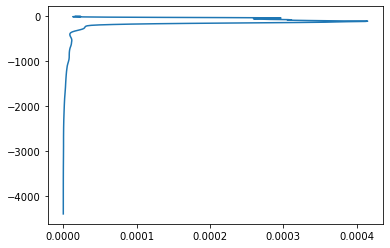

In [9]:
def cdif(x):
    return np.insert(x[2:]-x[:-2],[0,-1],[x[1]-x[0],x[-1]-x[-2]])

def grad(x,y):
    return cdif(y)/cdif(x)

n2 = -9.8*grad(ze,np.nanmean(przo,axis=0))/np.nanmean(przo,axis=0)
plt.plot(n2,ze)
plt.show()

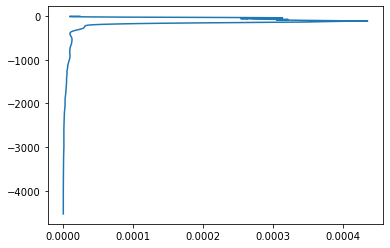

In [13]:
def Nsqrd(pT,S,lon,lat,z):
    p = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, p, lon, lat)
    CT = gsw.CT_from_pt(SA, pT)
    N2,pmid = gsw.Nsquared(SA, CT, p, lat)
    return N2,pmid
N2,pmid = Nsqrd(np.nanmean(pTzo,axis=0),np.nanmean(Szo,axis=0),lon_m,lat_m,ze)
zmid = gsw.z_from_p(pmid,lat_m)
plt.plot(N2,zmid)
plt.show()
import pandas as pd
pd.DataFrame(data={'z':zmid,'n2':N2}).to_csv('results/ofes/n2_Nias_H08_mid.csv',index=False)

In [5]:
dsr = xr.open_mfdataset('data/ofes/*5s95e_dy.cdf')
#Tr = dsr.T_20.interpolate_na(dim="depth", method="linear", fill_value="extrapolate")
#Sr = dsr.S_41.interpolate_na(dim="depth", method="linear", fill_value="extrapolate")

In [14]:
print(np.isnan(dsr.T_20.isel(depth=-1).values.flatten()).sum())
dsr.T_20

1


<xarray.DataArray 'T_20' (time: 365, depth: 12, lat: 1, lon: 1)>
dask.array<open_dataset-5b855c858c4981e767c74feb2d3c2d2bT_20, shape=(365, 12, 1, 1), dtype=float32, chunksize=(365, 12, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-01T12:00:00 ... 2005-12-31T12:00:00
  * depth    (depth) float32 1.5 25.0 50.0 75.0 ... 250.0 300.0 500.0 750.0
  * lat      (lat) float32 -5.0
  * lon      (lon) float32 95.0
Attributes:
    name:            T
    long_name:       TEMPERATURE (C)
    generic_name:    temp
    FORTRAN_format:  f10.2
    units:           C
    epic_code:       20

In [7]:
def pT(T, S, lon, lat, z):
    p = gsw.p_from_z(z, lat)
    SA = gsw.SA_from_SP(S, p, lon, lat)
    pT = gsw.pt0_from_t(SA, T, p)
    return pT

pTr = pT(Tr.values[:,:,0,0], Sr.values[:,:,0,0], lon_m, lat_m, -Tr.depth.values.reshape((1,-1)))
pTr = np.nanmean(np.flip(pTr,axis=1),axis=0)
zr = np.flip(-Tr.depth.values)
dTdzr = grad(zr,pTr)

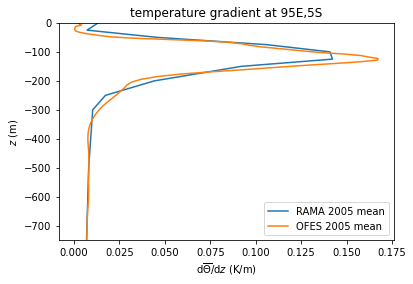

In [8]:
dTdzo = grad(ze,Tk.mean(axis=0))
plt.figure()
plt.plot(dTdzr,zr,label='RAMA 2005 mean')
plt.plot(dTdzo,ze,label='OFES 2005 mean')
plt.ylim([-750,0])
plt.xlabel(r'${\mathrm{d}\overline{\Theta}}/{\mathrm{d}z}$ (K/m)')
plt.ylabel(r'$z$ (m)')
plt.title(r'temperature gradient at 95E,5S')
plt.legend()
plt.savefig('results/ofes/dptdz_rama_ofes.pdf')
plt.show()

In [4]:
ds_temp.isel(lon=i_m,lat=j_m).to_netcdf('data/ofes/temp_ofes_2005_dy_sub.nc')
ds_salt.isel(lon=i_m,lat=j_m).to_netcdf('data/ofes/salinity_ofes_2005_dy_sub.nc')

In [5]:
T_2005_dy = np.full(ds_temp.temp.shape,np.nan)
for e,te in enumerate(dt_e):
    print(te)
    T_2005_dy[e] = T(ds_temp.temp[e], ds_salt.salinity[e], 
                     lon_e[i_m].reshape((1,1,-1)),lat_e[j_m].reshape((1,-1,1)), ze[::-1].reshape((-1,1,1)))

2005-01-01T00:00:00.000000000
2005-01-02T00:00:00.000000000
2005-01-03T00:00:00.000000000
2005-01-04T00:00:00.000000000
2005-01-05T00:00:00.000000000
2005-01-06T00:00:00.000000000
2005-01-07T00:00:00.000000000
2005-01-08T00:00:00.000000000
2005-01-09T00:00:00.000000000
2005-01-10T00:00:00.000000000
2005-01-11T00:00:00.000000000
2005-01-12T00:00:00.000000000
2005-01-13T00:00:00.000000000
2005-01-14T00:00:00.000000000
2005-01-15T00:00:00.000000000
2005-01-16T00:00:00.000000000
2005-01-17T00:00:00.000000000
2005-01-18T00:00:00.000000000
2005-01-19T00:00:00.000000000
2005-01-20T00:00:00.000000000
2005-01-21T00:00:00.000000000
2005-01-22T00:00:00.000000000
2005-01-23T00:00:00.000000000
2005-01-24T00:00:00.000000000
2005-01-25T00:00:00.000000000
2005-01-26T00:00:00.000000000
2005-01-27T00:00:00.000000000
2005-01-28T00:00:00.000000000
2005-01-29T00:00:00.000000000
2005-01-30T00:00:00.000000000
2005-01-31T00:00:00.000000000
2005-02-01T00:00:00.000000000
2005-02-02T00:00:00.000000000
2005-02-03

2005-10-22T00:00:00.000000000
2005-10-23T00:00:00.000000000
2005-10-24T00:00:00.000000000
2005-10-25T00:00:00.000000000
2005-10-26T00:00:00.000000000
2005-10-27T00:00:00.000000000
2005-10-28T00:00:00.000000000
2005-10-29T00:00:00.000000000
2005-10-30T00:00:00.000000000
2005-10-31T00:00:00.000000000
2005-11-01T00:00:00.000000000
2005-11-02T00:00:00.000000000
2005-11-03T00:00:00.000000000
2005-11-04T00:00:00.000000000
2005-11-05T00:00:00.000000000
2005-11-06T00:00:00.000000000
2005-11-07T00:00:00.000000000
2005-11-08T00:00:00.000000000
2005-11-09T00:00:00.000000000
2005-11-10T00:00:00.000000000
2005-11-11T00:00:00.000000000
2005-11-12T00:00:00.000000000
2005-11-13T00:00:00.000000000
2005-11-14T00:00:00.000000000
2005-11-15T00:00:00.000000000
2005-11-16T00:00:00.000000000
2005-11-17T00:00:00.000000000
2005-11-18T00:00:00.000000000
2005-11-19T00:00:00.000000000
2005-11-20T00:00:00.000000000
2005-11-21T00:00:00.000000000
2005-11-22T00:00:00.000000000
2005-11-23T00:00:00.000000000
2005-11-24

In [6]:
T_2005_dy = np.transpose(T_2005_dy[:,::-1,:,:],(0,3,2,1))
dT_2005_dy = T_2005_dy-T_2005_dy.mean(axis=0)

In [7]:
# interpolate horizontally onto great circle path
knots = (lon_e[i_m], lat_e[j_m])
locsk = np.empty([1,2])
locsk[:,0],locsk[:,1] = 95,-5

dTkze = np.zeros((1, nze))
for k in range(nze):
    itpT = RGI(knots, dT_2005_dy[0,:,:,k])
    dTkze[0,k] = itpT(locsk)

In [8]:
dTkze

array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan, -7.38642720e-04,
        -8.03510618e-04, -6.08635409e-04, -2.85843391e-04,
        -1.10948577e-03, -1.16915117e-02, -2.60260668e-02,
        -2.67133441e-02, -2.08618178e-02, -2.14795651e-02,
        -2.30327145e-02, -2.39914198e-02, -2.79402239e-02,
        -4.90788369e-02, -7.49830454e-02, -1.09859580e-01,
        -1.23248316e-01, -1.05410113e-01, -6.52626027e-02,
        -1.96006974e-02,  1.38236568e-02,  2.96395081e-02,
         5.36723857e-02,  7.10072920e-02,  7.86265136e-02,
         6.71223572e-02,  4.13792529e-02,  1.14754818e-02,
        -5.76214464e-03, -4.57199215e-03,  2.09902672e-02,
         3.55491147e-02,  4.21116583e-02,  4.64347674e-02,
         5.53685975e-02,  5.33912065e-02,  5.04827282e-02,
         3.32510212e-02,  1.50392769e-02, -5.32423621e-04,
        -1.11126328e-02, -1.60180890e-02, -2.26573730e-0

In [ ]:
    # interpolate vertically onto kernel grid
    # fill in the coastal and bottom points
    dTkze = fillbtm2(dTkze)
    knots = ze
    for i in range(nxk):
        itpT = interp1d(knots, dTkze[i,:])
        etpT = extrap1d(itpT)
        dTk[i,:] = etpT(zk) 

In [ ]:
ds = xr.Dataset(
    data_vars=dict(
        t_mean = (["lon", "lat", "z"], t_is_mean),),
    coords=dict(
        lon = lon_e,
        lat = lat_e,
        z = ze,),
        attrs=dict(description="In-situ temperature (K) mean from OFES 2005 daily"),
)
ds.to_netcdf('data/ofes/tref_ofes_2005_dy.nc')

In [ ]:
idx_k = np.where((lon_k>=lon_e.min()) & (lon_k<=lon_e.max()))[0]
# kernel coordinates
pTk = np.empty([nxk, nzk])
Sk = np.empty([nxk, nzk])

if wdtau:
    e0 = 0
    dtauSEM = np.zeros([len(fs),len(dt64_events)])
    dtauMODE = np.zeros([len(fs),len(dt64_events)])

for e, dt64 in enumerate(dt64_events[e0:]):
    if (vert or wdtau or wvel)==0:
        break
    print(dt64)
    
    pTe = np.swapaxes(np.flip(ds_temp.temp[e].values,axis=0),0,-1)
    Se = np.swapaxes(np.flip(ds_salt.salinity[e].values,axis=0),0,-1)
    pTe[pTe==0.] = np.nan
    Se[Se==0.] = np.nan
    nxe, nye, nze = pTe.shape
    # fill in the coastal and bottom points
    #pTe = filledges(pTe)
    #Se = filledges(Se)
    # interpolate horizontally onto great circle path
    knots = (lon_e, lat_e)
    locsk = np.empty([len(idx_k),2])
    locsk[:,0],locsk[:,1] = lon_k[idx_k],lat_k[idx_k]
    pTkze = np.full((nxk, nze),np.nan)
    Skze = np.full((nxk, nze),np.nan)
    for k in range(nze):
        itppT = RGI(knots, pTe[:,:,k])
        itpS = RGI(knots, Se[:,:,k])
        pTkze[idx_k,k] = itppT(locsk)
        Skze[idx_k,k] = itpS(locsk)
    # interpolate vertically onto kernel grid
    pTkze = fillbtm(pTkze,2)
    Skze = fillbtm(Skze,2)
    knots = ze
    for i in range(nxk):
        itppT = interp1d(knots, pTkze[i,:])
        itpS = interp1d(knots, Skze[i,:])
        etppT = extrap1d(itppT)
        etpS = extrap1d(itpS)
        pTk[i,:] = etppT(zk)
        Sk[i,:] = etpS(zk)     
    # calculate in situ temperature
    Tk = T(pTk, Sk, lon_k.reshape((-1,1)), lat_k.reshape((-1,1)), zk.reshape((1,-1)))
    dT = Tk-T_bar
    if wdtau:
        for j in range(len(fs)):
            dtauSEM[j,e] = np.nansum(ds.SEMkernels_T[j]*dT)*dxk*dzk
            dtauMODE[j,e] = np.nansum(ds.MODEkernels_T[j]*dT)*dxk*dzk